# Pattern Recognition - Low Market Cap Crypto

In [246]:
#Loading basic libraries
import pandas as pd
import sqlalchemy
import asyncio
import nest_asyncio
import tensorflow as tf
import datetime, time
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
import time
import seaborn as sns

#loading binance API
from binance.client import Client 

#loading model related libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Reshape, Flatten, BatchNormalization, MaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator
from binance import AsyncClient, BinanceSocketManager
from tensorflow import keras 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Nadam
from keras import regularizers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import backend as K
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import arange
tf.config.run_functions_eagerly(True)

In [71]:
#Creating optimisation save locations
LOG_DIR = f"{int(time.time())}cnn"
LOG_DIR_LSTM = f"{int(time.time())}lstm"

## Calling Binance API Key

Unique Binance API key, Used to fetch data from the Binance cloud.

In [26]:
#Retrieving API Keys from an external file.
%run ./Binance_keys.ipynb

In [27]:
#opening a new binance client
client = Client(api_key, api_secret)

## Fetching Historical Data

In [28]:
howLong = 365
# Calculate the timestamps for the binance api function
untilThisDate = datetime.datetime.now()
sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
# Execute the query from binance - timestamps must be converted to strings !
candle = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1DAY, str(sinceThisDate), str(untilThisDate))

# Create a dataframe to label all the columns returned by binance so we work with them later.
df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
# as timestamp is returned in ms, let us convert this back to proper timestamps.
df.dateTime = pd.to_datetime(df.dateTime, unit='ms')

# Get rid of columns we do not need
df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)

print(df)

      dateTime          open          high           low         close  \
0   2021-04-27  535.33000000  579.50000000  525.00000000  568.78000000   
1   2021-04-28  568.78000000  578.88000000  538.00000000  562.78000000   
2   2021-04-29  562.78000000  615.29000000  554.00000000  599.70000000   
3   2021-04-30  599.66000000  628.00000000  585.72000000  622.65000000   
4   2021-05-01  622.64000000  645.57000000  609.21000000  620.00000000   
..         ...           ...           ...           ...           ...   
360 2022-04-22  404.90000000  413.90000000  403.30000000  406.60000000   
361 2022-04-23  406.60000000  408.10000000  397.30000000  401.10000000   
362 2022-04-24  401.20000000  405.50000000  397.10000000  398.80000000   
363 2022-04-25  398.80000000  405.70000000  382.30000000  404.30000000   
364 2022-04-26  404.40000000  407.50000000  386.30000000  389.70000000   

               volume  
0    2807308.61980000  
1    2384514.88520000  
2    4336516.33470000  
3    3430512.40

In [29]:
#creating performance metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Split Seq and Pearson Functions

In [30]:
#split sequence function
def split_sq(seq, num_pieces):
    start = 0
    for i in range(num_pieces):
        stop = start + len(seq[i::num_pieces])
        yield seq[start:stop]
        start = stop
#pearson correlation function
def pearson(s1, s2):
    s1_c = s1-np.mean(s1)
    s2_c = s2-np.mean(s2)
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

## Converting Historical Data into a Timeseries Data

In [31]:
#converting historical data into a time-series dataframe
cryp_df = df.sort_values('dateTime', ascending=True)

lookback = 30
dates = cryp_df['dateTime']
prices = list(cryp_df['close'].values)
counter_ = -1
price_series = []
for day in dates:
    counter_ += 1
    if counter_ >= lookback:
        price_series.append(prices[counter_-lookback:counter_])
        
timeseries_df = pd.DataFrame(price_series)

In [32]:
#reviewing the shape of the data
timeseries_df.shape

(335, 30)

In [33]:
#looking at the transformed data
timeseries_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,568.78000000,562.78000000,599.70000000,622.65000000,620.00000000,621.78000000,676.15000000,609.30000000,651.10000000,633.99000000,...,512.07000000,507.88000000,334.80000000,391.17000000,326.01000000,299.76000000,260.72000000,345.64000000,343.18000000,379.16000000
1,562.78000000,599.70000000,622.65000000,620.00000000,621.78000000,676.15000000,609.30000000,651.10000000,633.99000000,624.30000000,...,507.88000000,334.80000000,391.17000000,326.01000000,299.76000000,260.72000000,345.64000000,343.18000000,379.16000000,369.67000000
2,599.70000000,622.65000000,620.00000000,621.78000000,676.15000000,609.30000000,651.10000000,633.99000000,624.30000000,646.10000000,...,334.80000000,391.17000000,326.01000000,299.76000000,260.72000000,345.64000000,343.18000000,379.16000000,369.67000000,328.82000000
3,622.65000000,620.00000000,621.78000000,676.15000000,609.30000000,651.10000000,633.99000000,624.30000000,646.10000000,661.74000000,...,391.17000000,326.01000000,299.76000000,260.72000000,345.64000000,343.18000000,379.16000000,369.67000000,328.82000000,305.04000000
4,620.00000000,621.78000000,676.15000000,609.30000000,651.10000000,633.99000000,624.30000000,646.10000000,661.74000000,631.10000000,...,326.01000000,299.76000000,260.72000000,345.64000000,343.18000000,379.16000000,369.67000000,328.82000000,305.04000000,325.57000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,408.40000000,414.20000000,410.30000000,415.80000000,430.50000000,430.20000000,434.20000000,442.10000000,428.90000000,447.70000000,...,413.60000000,423.40000000,414.70000000,417.30000000,417.30000000,406.60000000,416.80000000,422.30000000,418.40000000,404.90000000
331,414.20000000,410.30000000,415.80000000,430.50000000,430.20000000,434.20000000,442.10000000,428.90000000,447.70000000,437.20000000,...,423.40000000,414.70000000,417.30000000,417.30000000,406.60000000,416.80000000,422.30000000,418.40000000,404.90000000,406.60000000
332,410.30000000,415.80000000,430.50000000,430.20000000,434.20000000,442.10000000,428.90000000,447.70000000,437.20000000,450.40000000,...,414.70000000,417.30000000,417.30000000,406.60000000,416.80000000,422.30000000,418.40000000,404.90000000,406.60000000,401.10000000
333,415.80000000,430.50000000,430.20000000,434.20000000,442.10000000,428.90000000,447.70000000,437.20000000,450.40000000,447.60000000,...,417.30000000,417.30000000,406.60000000,416.80000000,422.30000000,418.40000000,404.90000000,406.60000000,401.10000000,398.80000000


## Ideal Market States

<function matplotlib.pyplot.show(close=None, block=None)>

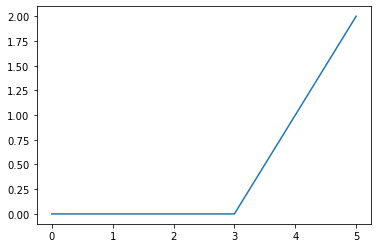

In [34]:
#Creating Ideal Shapes
correlate_against_bull = [0,0,0,0,1,2]
plt.plot(correlate_against_bull)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

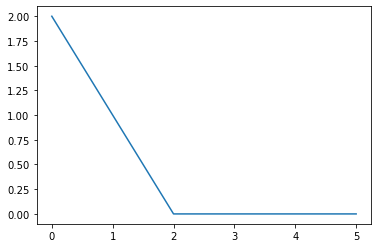

In [35]:
#Creating Ideal Shapes
correlate_against_bear = [2,1,0,0,0,0]
plt.plot(correlate_against_bear)
plt.show

## Declaring Labels Dataframe

In [36]:
#predefining labels dataframe
market_type = []
for i in range (332):
    market_type.append('4')
type_df = pd.DataFrame(market_type)

## Labelling the Dataset

In [238]:
#iterating through the data and labelling data
complexity = 6
counter = 0
for index, row in timeseries_df.iterrows():
    counter += 1
    simplified_values = []
    for r in split_sq(list(row.values), complexity):
        simplified_values.append(np.mean(np.array(r).astype(float)))
    corbull = pearson(simplified_values,correlate_against_bull)
    corbear = pearson(simplified_values,correlate_against_bear)
    #if the correlation is greater than 50% data is assign the larger correlation state
    if corbull > 0.5 or corbear > 0.5:
        if corbull > corbear:
            print('Market Type: Bullish')
            print('Percentage Correllation: %' + str(np.round(corbull,2)*100))
            date = df.iloc[[counter],0]
            print(date.dt.strftime("In date: %d-%b-%Y"))
            type_df.at[counter, 'marketType'] = 2
        else:
            print('Market Type: Bearish')
            print('Percentage Correllation: %' + str(np.round(corbear,2)*100))
            date = df.iloc[[counter],0]
            print(date.dt.strftime("In date: %d-%b-%Y"))
            type_df.at[counter, 'marketType'] = 1
    else:
        type_df.at[counter, 'marketType'] = 3
CATEGORIES = ["Bearish", "Bullish", "Neutral"]

Market Type: Bearish
Percentage Correllation: %55.00000000000001
3    In date: 30-Apr-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %62.0
4    In date: 01-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %67.0
5    In date: 02-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %73.0
6    In date: 03-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %76.0
7    In date: 04-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %78.0
8    In date: 05-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %86.0
9    In date: 06-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %89.0
10    In date: 07-May-2021
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %94.0
11    In date: 08-May-2021
Name: dateTime, dtype: object
Market Type: 

Market Type: Bearish
Percentage Correllation: %61.0
284    In date: 05-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %68.0
285    In date: 06-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %79.0
286    In date: 07-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %84.0
287    In date: 08-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %75.0
288    In date: 09-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %78.0
289    In date: 10-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %76.0
290    In date: 11-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %84.0
291    In date: 12-Feb-2022
Name: dateTime, dtype: object
Market Type: Bearish
Percentage Correllation: %81.0
292    In date: 13-Feb-2022
Name: dateTime, dtype: object
Market Typ

In [38]:
#removing unneeded columns
type_df.dropna(subset = ["marketType"], inplace=True)

## Dataset Preprocessing

In [39]:
#reshaping training data 
market_df = timeseries_df.to_numpy()
market_df = market_df.reshape((-1,30))
#scaling data
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(market_df)
market_df = pd.DataFrame(x_scaled)
#splitting data
market_train, market_test, type_train, type_test = train_test_split(market_df, type_df['marketType'], test_size=0.20, random_state=42)

market_train = np.array(market_train).astype("float32")
market_test = np.array(market_test).astype("float32")

type_train = np.array(type_train).astype("float32")
type_test = np.array(type_test).astype("float32")

## One-hot Encoding Labels

In [40]:
#encoding labels using one-hot encoding
enc = LabelEncoder()
enc.fit(type_train)
new_types = enc.transform(type_train)
new_types = new_types.reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
new_train_labs = ohe.fit_transform(new_types)

enc.fit(type_test)
new_types = enc.transform(type_test)
new_types = new_types.reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
new_test_labs = ohe.fit_transform(new_types)

## Data Shape Preview

In [41]:
#reshaping data to fit lstm and 1d cnn input requirements 
market_train_l = tf.reshape(market_train,(market_train.shape[0], market_train.shape[1], 1))
market_test_l = tf.reshape(market_test,(market_test.shape[0], market_test.shape[1], 1))
market_train_l.shape

TensorShape([268, 30, 1])

In [42]:
#reviewing labels shape
new_test_labs.shape

(67, 3)

# Initial LSTM Model

In [43]:
#creating initial lstm model
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape=(30, 1), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________


In [45]:
#initial lstm run
num_epochs = 25
lstm_hist = model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=num_epochs, batch_size = 10)

Epoch 1/25
 1/27 [>.............................] - ETA: 2s - loss: 8.5189 - accuracy: 0.6000

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


27/27 [==============================] - 3s 100ms/step - loss: 5.3160 - accuracy: 0.3321 - val_loss: 5.4819 - val_accuracy: 0.3134
Epoch 2/25
27/27 [==============================] - 3s 99ms/step - loss: 4.5665 - accuracy: 0.3843 - val_loss: 1.2795 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 3s 98ms/step - loss: 2.6399 - accuracy: 0.3806 - val_loss: 1.1411 - val_accuracy: 0.2090
Epoch 4/25
27/27 [==============================] - 3s 97ms/step - loss: 2.7500 - accuracy: 0.3507 - val_loss: 1.1397 - val_accuracy: 0.2985
Epoch 5/25
27/27 [==============================] - 3s 102ms/step - loss: 1.9288 - accuracy: 0.3022 - val_loss: 1.1349 - val_accuracy: 0.2090
Epoch 6/25
27/27 [==============================] - 3s 98ms/step - loss: 1.8454 - accuracy: 0.3134 - val_loss: 1.1307 - val_accuracy: 0.2090
Epoch 7/25
27/27 [==============================] - 3s 99ms/step - loss: 1.8662 - accuracy: 0.3470 - val_loss: 1.1267 - val_accuracy: 0.2090
Epoch 8/25
27/27 [====

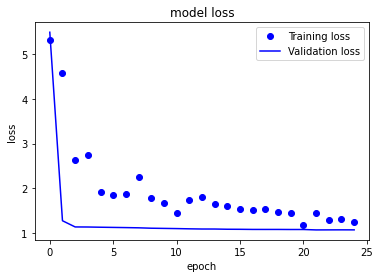

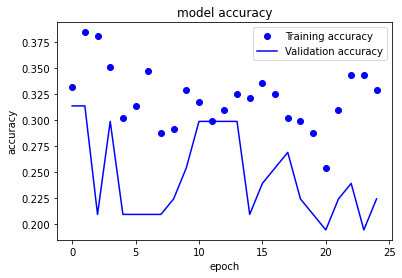

In [136]:
#displaying lstm results.
blue_dots = 'bo'
solid_blue_line = 'b'

plt.plot(lstm_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Initial 1D CNN Model

In [48]:
#creating initial 1d cnn models 
cnn1_m = Sequential()
cnn1_m.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(30, 1)))
cnn1_m.add(Conv1D(64, kernel_size=3, activation="relu"))
cnn1_m.add(MaxPooling1D(pool_size=3))
cnn1_m.add(BatchNormalization())

cnn1_m.add(Conv1D(16, kernel_size=3, activation="relu"))
cnn1_m.add(Conv1D(16, kernel_size=3, activation="relu"))
cnn1_m.add(MaxPooling1D(pool_size=3))
cnn1_m.add(BatchNormalization())

cnn1_m.add(Flatten())
cnn1_m.add(Dense(64, activation='relu'))
cnn1_m.add(Dropout(0.3))

cnn1_m.add(Dense(3, activation="softmax"))

cnn1_m.compile(optimizer=keras.optimizers.Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn1_m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 16)             3088      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 16)             784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 16)            

In [49]:
#running initial 1d cnn model
num_epochs = 25
od_hist = cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=num_epochs)

Epoch 1/25
9/9 [==============================] - 0s 29ms/step - loss: 1.2718 - accuracy: 0.3284 - val_loss: 1.0979 - val_accuracy: 0.3284
Epoch 2/25
9/9 [==============================] - 0s 27ms/step - loss: 1.1400 - accuracy: 0.3993 - val_loss: 1.0980 - val_accuracy: 0.3582
Epoch 3/25
9/9 [==============================] - 0s 26ms/step - loss: 1.1061 - accuracy: 0.3769 - val_loss: 1.0982 - val_accuracy: 0.3433
Epoch 4/25
9/9 [==============================] - 0s 25ms/step - loss: 0.9967 - accuracy: 0.4888 - val_loss: 1.0981 - val_accuracy: 0.4179
Epoch 5/25
9/9 [==============================] - 0s 28ms/step - loss: 0.9678 - accuracy: 0.5149 - val_loss: 1.0981 - val_accuracy: 0.4328
Epoch 6/25
9/9 [==============================] - 0s 26ms/step - loss: 0.9944 - accuracy: 0.4552 - val_loss: 1.0980 - val_accuracy: 0.4179
Epoch 7/25
9/9 [==============================] - 0s 25ms/step - loss: 0.9383 - accuracy: 0.5597 - val_loss: 1.0977 - val_accuracy: 0.4478
Epoch 8/25
9/9 [===========

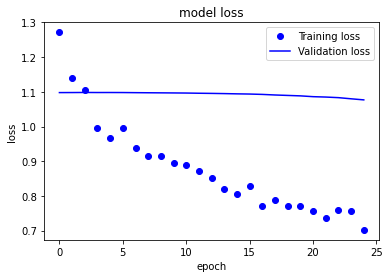

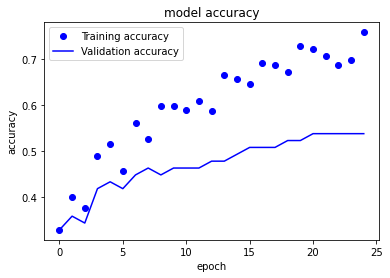

In [137]:
#displaying 1d cnn results
plt.plot(od_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(od_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(od_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(od_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# K-Fold Cross Validation

## LSTM Cross Validation

In [52]:
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
LSTM_initial_CV = pd.DataFrame()
LSTM_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    LSTM_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    ktest = Sequential()
    ktest.add(LSTM(64, activation = 'relu', input_shape=(30, 1), return_sequences=True))
    ktest.add(LSTM(32, activation = 'relu', return_sequences=False))
    ktest.add(Dropout(0.2))
    ktest.add(Dense(3))
    ktest.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    ktest.fit(market_train_n, new_labs_k, epochs=10, batch_size = 30, verbose=1)
    resultsTest = ktest.evaluate(market_test_n, new_labs_k_test)
    LSTM_results.append(resultsTest[0])
    LSTM_results.append(resultsTest[1])
    LSTM_cv_results.append(LSTM_results)

Epoch 1/10
1/9 [==>...........................] - ETA: 0s - loss: 8.0722 - accuracy: 0.3667

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 89ms/step - loss: 9.0925 - accuracy: 0.3942
Epoch 2/10
9/9 [==============================] - 1s 89ms/step - loss: 2.7291 - accuracy: 0.4108
Epoch 3/10
9/9 [==============================] - 1s 100ms/step - loss: 1.1724 - accuracy: 0.3693
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0674 - accuracy: 0.3444
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0793 - accuracy: 0.3859
Epoch 6/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0565 - accuracy: 0.4066
Epoch 7/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0831 - accuracy: 0.3734
Epoch 8/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0853 - accuracy: 0.3859
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1137 - accuracy: 0.4523
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 1.0439 - accuracy: 0.5926
Epoch 1/10
1/9 [==>....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 90ms/step - loss: 1.2823 - accuracy: 0.2988
Epoch 2/10
9/9 [==============================] - 1s 91ms/step - loss: 1.1048 - accuracy: 0.4025
Epoch 3/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1001 - accuracy: 0.3859
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1187 - accuracy: 0.3817
Epoch 5/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0902 - accuracy: 0.3900
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0709 - accuracy: 0.3942
Epoch 7/10
9/9 [==============================] - 1s 99ms/step - loss: 1.0554 - accuracy: 0.3942
Epoch 8/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0292 - accuracy: 0.3983
Epoch 9/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0033 - accuracy: 0.3776
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.9705 - accuracy: 0.4444
Epoch 1/10
1/9 [==>.....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 90ms/step - loss: 1.4482 - accuracy: 0.3527
Epoch 2/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1721 - accuracy: 0.3817
Epoch 3/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1022 - accuracy: 0.4564
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0147 - accuracy: 0.4564
Epoch 5/10
9/9 [==============================] - 1s 90ms/step - loss: 0.9760 - accuracy: 0.4855
Epoch 6/10
9/9 [==============================] - 1s 89ms/step - loss: 0.9850 - accuracy: 0.4730
Epoch 7/10
9/9 [==============================] - 1s 89ms/step - loss: 0.9182 - accuracy: 0.4149
Epoch 8/10
9/9 [==============================] - 1s 89ms/step - loss: 0.9000 - accuracy: 0.5311
Epoch 9/10
9/9 [==============================] - 1s 90ms/step - loss: 2.0034 - accuracy: 0.4398
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 1.1272 - accuracy: 0.4074
Epoch 1/10
1/9 [==>.....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 91ms/step - loss: 1.6489 - accuracy: 0.2780
Epoch 2/10
9/9 [==============================] - 1s 90ms/step - loss: 1.2027 - accuracy: 0.3900
Epoch 3/10
9/9 [==============================] - 1s 91ms/step - loss: 1.1903 - accuracy: 0.3527
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1092 - accuracy: 0.3527
Epoch 5/10
9/9 [==============================] - 1s 101ms/step - loss: 1.0817 - accuracy: 0.3942
Epoch 6/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0886 - accuracy: 0.3776
Epoch 7/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0663 - accuracy: 0.4025
Epoch 8/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0686 - accuracy: 0.4108
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1735 - accuracy: 0.4066
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 1.0009 - accuracy: 0.4074
Epoch 1/10
1/9 [==>....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 90ms/step - loss: 2.6800 - accuracy: 0.3361
Epoch 2/10
9/9 [==============================] - 1s 90ms/step - loss: 1.4221 - accuracy: 0.3817
Epoch 3/10
9/9 [==============================] - 1s 91ms/step - loss: 1.3345 - accuracy: 0.3610
Epoch 4/10
9/9 [==============================] - 1s 90ms/step - loss: 1.2570 - accuracy: 0.3485
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1819 - accuracy: 0.3776
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0956 - accuracy: 0.3444
Epoch 7/10
9/9 [==============================] - 1s 91ms/step - loss: 1.0847 - accuracy: 0.4357
Epoch 8/10
9/9 [==============================] - 1s 100ms/step - loss: 1.1033 - accuracy: 0.3444
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1197 - accuracy: 0.3320
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 1.0730 - accuracy: 0.3704
Epoch 1/10
1/9 [==>....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 89ms/step - loss: 2.2452 - accuracy: 0.3195
Epoch 2/10
9/9 [==============================] - 1s 89ms/step - loss: 1.2997 - accuracy: 0.3776
Epoch 3/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0915 - accuracy: 0.3983
Epoch 4/10
9/9 [==============================] - 1s 93ms/step - loss: 1.1141 - accuracy: 0.3693
Epoch 5/10
9/9 [==============================] - 1s 90ms/step - loss: 1.2214 - accuracy: 0.3402
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1259 - accuracy: 0.3320
Epoch 7/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1029 - accuracy: 0.2863
Epoch 8/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0723 - accuracy: 0.4025
Epoch 9/10
9/9 [==============================] - 1s 91ms/step - loss: 1.0831 - accuracy: 0.3734
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 1.0071 - accuracy: 0.4074
Epoch 1/10
1/9 [==>.....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 92ms/step - loss: 1.2916 - accuracy: 0.3361
Epoch 2/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1256 - accuracy: 0.2905
Epoch 3/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0919 - accuracy: 0.4025
Epoch 4/10
9/9 [==============================] - 1s 92ms/step - loss: 1.0824 - accuracy: 0.4108
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0794 - accuracy: 0.3734
Epoch 6/10
9/9 [==============================] - 1s 100ms/step - loss: 1.1422 - accuracy: 0.3444
Epoch 7/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1440 - accuracy: 0.3154
Epoch 8/10
9/9 [==============================] - 1s 91ms/step - loss: 1.0977 - accuracy: 0.3320
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0660 - accuracy: 0.3817
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 1.0252 - accuracy: 0.5556
Epoch 1/10
1/9 [==>....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 90ms/step - loss: 5.0990 - accuracy: 0.3361
Epoch 2/10
9/9 [==============================] - 1s 89ms/step - loss: 1.2815 - accuracy: 0.3444
Epoch 3/10
9/9 [==============================] - 1s 88ms/step - loss: 1.1273 - accuracy: 0.3320
Epoch 4/10
9/9 [==============================] - 1s 88ms/step - loss: 1.1138 - accuracy: 0.3361
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0932 - accuracy: 0.3817
Epoch 6/10
9/9 [==============================] - 1s 88ms/step - loss: 1.1048 - accuracy: 0.3485
Epoch 7/10
9/9 [==============================] - 1s 88ms/step - loss: 1.0703 - accuracy: 0.3651
Epoch 8/10
9/9 [==============================] - 1s 88ms/step - loss: 1.0741 - accuracy: 0.3568
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 1.0624 - accuracy: 0.4025
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 1.0527 - accuracy: 0.4074
Epoch 1/10
1/9 [==>.....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 88ms/step - loss: 4.9669 - accuracy: 0.3760
Epoch 2/10
9/9 [==============================] - 1s 89ms/step - loss: 1.5891 - accuracy: 0.3471
Epoch 3/10
9/9 [==============================] - 1s 88ms/step - loss: 1.2598 - accuracy: 0.3264
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1081 - accuracy: 0.3678
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1323 - accuracy: 0.3843
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1050 - accuracy: 0.3471
Epoch 7/10
9/9 [==============================] - 1s 91ms/step - loss: 1.0905 - accuracy: 0.3471
Epoch 8/10
9/9 [==============================] - 1s 91ms/step - loss: 1.0756 - accuracy: 0.3843
Epoch 9/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0746 - accuracy: 0.4091
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.9973 - accuracy: 0.5000
Epoch 1/10
1/9 [==>.....................

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 93ms/step - loss: 2.2016 - accuracy: 0.3636
Epoch 2/10
9/9 [==============================] - 1s 90ms/step - loss: 1.2976 - accuracy: 0.3264
Epoch 3/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1748 - accuracy: 0.3636
Epoch 4/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1209 - accuracy: 0.3760
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 1.1202 - accuracy: 0.3554
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1103 - accuracy: 0.3884
Epoch 7/10
9/9 [==============================] - 1s 90ms/step - loss: 1.0850 - accuracy: 0.3760
Epoch 8/10
9/9 [==============================] - 1s 100ms/step - loss: 1.0903 - accuracy: 0.3760
Epoch 9/10
9/9 [==============================] - 1s 90ms/step - loss: 1.1006 - accuracy: 0.3967
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 1.0640 - accuracy: 0.3846


In [53]:
#storing cross validation in a dataframe and reviewing data
LSTM_initial_CV = pd.DataFrame(LSTM_cv_results, 
             columns=['Loss', 
                      'Accuracy'])
LSTM_initial_CV

,Loss,Accuracy
0,1.043914,0.592593
1,0.970463,0.444444
2,1.127185,0.407407
3,1.000926,0.407407
4,1.073030,0.370370
5,1.007109,0.407407
6,1.025165,0.555556
7,1.052744,0.407407
8,0.997272,0.500000
9,1.063990,0.384615


## 1D CNN Cross Validation

In [54]:
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
CNN_initial_CV = pd.DataFrame()
CNN_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    CNN_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    cnn1_k = Sequential()
    cnn1_k.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(30, 1)))
    cnn1_k.add(Conv1D(64, kernel_size=3, activation="relu"))
    cnn1_k.add(MaxPooling1D(pool_size=3))
    cnn1_k.add(BatchNormalization())

    cnn1_k.add(Conv1D(16, kernel_size=3, activation="relu"))
    cnn1_k.add(Conv1D(16, kernel_size=3, activation="relu"))
    cnn1_k.add(MaxPooling1D(pool_size=3))
    cnn1_k.add(BatchNormalization())

    cnn1_k.add(Flatten())
    cnn1_k.add(Dense(64, activation='relu'))
    cnn1_k.add(Dropout(0.3))

    cnn1_k.add(Dense(3, activation="softmax"))

    cnn1_k.compile(optimizer=keras.optimizers.Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
    
    num_epochs = 10
    cnn1_k.fit(market_train_n, new_labs_k, epochs=num_epochs)
    
    resultsTest = cnn1_k.evaluate(market_test_n, new_labs_k_test)
    CNN_results.append(resultsTest[0])
    CNN_results.append(resultsTest[1])
    CNN_cv_results.append(CNN_results)

Epoch 1/10
4/8 [==============>...............] - ETA: 0s - loss: 1.3007 - accuracy: 0.2734

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 22ms/step - loss: 1.2667 - accuracy: 0.3071
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.2109 - accuracy: 0.3361
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1650 - accuracy: 0.3029
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1872 - accuracy: 0.3485
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1516 - accuracy: 0.3734
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0941 - accuracy: 0.4357
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0549 - accuracy: 0.4274
Epoch 8/10
8/8 [==============================] - 0s 22ms/step - loss: 1.0539 - accuracy: 0.4191
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0743 - accuracy: 0.4647
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.1000 - accuracy: 0.3333
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 22ms/step - loss: 1.2838 - accuracy: 0.3112
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 1.1698 - accuracy: 0.3734
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1214 - accuracy: 0.3859
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0598 - accuracy: 0.4357
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0518 - accuracy: 0.4772
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0178 - accuracy: 0.4938
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9595 - accuracy: 0.5353
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9432 - accuracy: 0.5477
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9461 - accuracy: 0.5685
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 1.0912 - accuracy: 0.3704
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.1171 - accuracy: 0.3859
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0773 - accuracy: 0.4398
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0550 - accuracy: 0.4191
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0196 - accuracy: 0.4315
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9546 - accuracy: 0.5477
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9665 - accuracy: 0.4896
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9350 - accuracy: 0.5768
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.8928 - accuracy: 0.5685
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9317 - accuracy: 0.5394
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.0986 - accuracy: 0.3333
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.1124 - accuracy: 0.4730
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0820 - accuracy: 0.4564
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0003 - accuracy: 0.5104
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9933 - accuracy: 0.5353
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9486 - accuracy: 0.5228
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9425 - accuracy: 0.5851
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9336 - accuracy: 0.5809
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.8787 - accuracy: 0.6432
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.8828 - accuracy: 0.6224
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 1.1162 - accuracy: 0.3704
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 22ms/step - loss: 1.1665 - accuracy: 0.3610
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0885 - accuracy: 0.3942
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0342 - accuracy: 0.4315
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0821 - accuracy: 0.3942
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0207 - accuracy: 0.4896
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9919 - accuracy: 0.5104
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9637 - accuracy: 0.5104
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9816 - accuracy: 0.5021
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9639 - accuracy: 0.4896
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.0949 - accuracy: 0.3333
Epoch 1/10
4/8 [==============>.........

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.0652 - accuracy: 0.4149
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0471 - accuracy: 0.4274
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0318 - accuracy: 0.4274
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0023 - accuracy: 0.4523
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9882 - accuracy: 0.5021
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9386 - accuracy: 0.5560
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9792 - accuracy: 0.4938
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9522 - accuracy: 0.5228
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9244 - accuracy: 0.5768
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.0946 - accuracy: 0.2963
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.2953 - accuracy: 0.3112
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 1.1906 - accuracy: 0.3734
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1325 - accuracy: 0.4025
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1144 - accuracy: 0.3900
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0830 - accuracy: 0.4274
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0899 - accuracy: 0.4398
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0552 - accuracy: 0.4647
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0446 - accuracy: 0.4647
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9782 - accuracy: 0.5104
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.0901 - accuracy: 0.4074
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.2707 - accuracy: 0.3651
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1871 - accuracy: 0.3942
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1454 - accuracy: 0.4149
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1145 - accuracy: 0.4398
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1000 - accuracy: 0.4066
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0743 - accuracy: 0.4647
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0182 - accuracy: 0.5145
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9960 - accuracy: 0.5311
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9858 - accuracy: 0.5062
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.0944 - accuracy: 0.4074
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.1508 - accuracy: 0.3678
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1133 - accuracy: 0.3719
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1128 - accuracy: 0.3760
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0629 - accuracy: 0.4132
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0758 - accuracy: 0.4174
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0530 - accuracy: 0.4628
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0142 - accuracy: 0.4793
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0450 - accuracy: 0.4545
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0025 - accuracy: 0.5124
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.1001 - accuracy: 0.2692
Epoch 1/10
7/8 [========================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 21ms/step - loss: 1.1373 - accuracy: 0.3264
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0636 - accuracy: 0.4545
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0615 - accuracy: 0.4215
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0348 - accuracy: 0.4174
Epoch 5/10
8/8 [==============================] - 0s 22ms/step - loss: 1.0013 - accuracy: 0.4669
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 1.0001 - accuracy: 0.4504
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9878 - accuracy: 0.4752
Epoch 8/10
8/8 [==============================] - 0s 22ms/step - loss: 0.9389 - accuracy: 0.5620
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.9358 - accuracy: 0.5248
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 1.0923 - accuracy: 0.3846


In [55]:
#storing cross validation in a dataframe and reviewing data
CNN_initial_CV = pd.DataFrame(CNN_cv_results, 
             columns=['Loss', 
                      'Accuracy'])
CNN_initial_CV

,Loss,Accuracy
0,1.100027,0.333333
1,1.091177,0.370370
2,1.098647,0.333333
3,1.116175,0.370370
4,1.094912,0.333333
5,1.094649,0.296296
6,1.090057,0.407407
7,1.094446,0.407407
8,1.100092,0.269231
9,1.092290,0.384615


# Hyper Parameter Testing

In [72]:
#building a 1d cnn model function that utilises hyper-parameters ranges
def cnn1_build(hp):
    cnn1_r = Sequential()
    cnn1_r.add(Conv1D(hp.Int('input_unit',min_value=32,max_value=512,step=32), kernel_size=1, activation="relu", input_shape=(market_train_n.shape[1:])))
    cnn1_r.add(Conv1D(hp.Int('cnn_2nd_input_units',min_value=32,max_value=512,step=32), kernel_size=1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    cnn1_r.add(MaxPooling1D(pool_size=1))
    cnn1_r.add(BatchNormalization())
    
    for i in range(hp.Int('n_layers', 1, 4)):
        cnn1_r.add(Conv1D(hp.Int(f'cnn_{i}_units',min_value=32,max_value=512,step=32), kernel_size=1, activation=hp.Choice(f'cnn_{i}_activation',values=['relu', 'sigmoid'],default='relu')))
        cnn1_r.add(Conv1D(hp.Int(f'cnn_{i}_units',min_value=32,max_value=512,step=32), kernel_size=1, activation=hp.Choice(f'cnn_{i}_activation',values=['relu', 'sigmoid'],default='relu')))
        cnn1_r.add(MaxPooling1D(pool_size=1))
        cnn1_r.add(BatchNormalization())

    cnn1_r.add(Flatten())
    cnn1_r.add(Dense(hp.Int('dense_neurons',min_value=32,max_value=512,step=32), activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    cnn1_r.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    cnn1_r.add(Dense(new_train_labs.shape[1], activation=hp.Choice('out_dense_activation',values=['relu', 'sigmoid'],default='relu')))

    cnn1_r.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    return cnn1_r
#calling random search
tuner = RandomSearch(
    cnn1_build,
    objective = 'val_accuracy',
    max_trials = 250,
    executions_per_trial = 1,
    directory = LOG_DIR)
#activating random search
tuner.search(x=market_train_l,
             y=new_train_labs,
            epochs = 25,
            batch_size=30,
            validation_data=(market_test_l, new_test_labs))

Trial 250 Complete [00h 00m 28s]
val_accuracy: 0.611940324306488

Best val_accuracy So Far: 0.8507462739944458
Total elapsed time: 01h 49m 10s
INFO:tensorflow:Oracle triggered exit


In [57]:
#building a lstm model function that utilises hyper-parameters ranges
def build_lstm(hp):
    lstm_r = Sequential()
    lstm_r.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),
                    return_sequences=True, input_shape=(market_train_n.shape[1:])))
    for i in range(hp.Int('n_layers', 1, 4)):
        lstm_r.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    lstm_r.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    lstm_r.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    lstm_r.add(Dense(new_train_labs.shape[1], 
                     activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    lstm_r.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return lstm_r
#calling random search
lstm_tuner = RandomSearch(
    build_lstm,
    objective = 'val_accuracy',
    max_trials = 250,
    executions_per_trial = 1,
    directory = LOG_DIR_LSTM)
#activating random search
lstm_tuner.search(x=market_train_l,
             y=new_train_labs,
            epochs = 25,
            batch_size=30,
            validation_data=(market_test_l, new_test_labs))

Trial 250 Complete [00h 02m 58s]
val_accuracy: 0.9104477763175964

Best val_accuracy So Far: 0.9850746393203735
Total elapsed time: 09h 41m 26s
INFO:tensorflow:Oracle triggered exit


# Best 1D CNN Model

In [73]:
#reloading the random search results and outputting the best model
tuner.reload()
best_cnn_model = tuner.get_best_models(num_models=1)[0]
best_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 320)           640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 288)           92448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 288)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 288)           1152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 160)           46240     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 160)           25760     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 160)           0

In [75]:
#outputting more detailed information on hyper-parameters
best_cnn_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv1d_input'}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d',
    'trainable': True,
    'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'filters': 320,
    'kernel_size': (1,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_1',
    'trainable': True,
    'dtype': 'float32',
    'fi

# Best LSTM Model

In [60]:
#reloading the random search results and outputting the best model
lstm_tuner.reload()
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]
best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 352)           498432    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           623616    
_________________________________________________________________
lstm_2 (LSTM)                (None, 160)               266880    
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 483       
Total params: 1,389,411
Trainable params: 1,389,411
Non-trainable params: 0
_________________________________________________________________


In [61]:
#outputting more detailed information on hyper-parameters
best_lstm_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 352,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'acti

# Cross Validation 

In [67]:
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
fin_LSTM_initial_CV = pd.DataFrame()
fin_LSTM_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    fin_LSTM_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    lstm_fincv_model = Sequential()
    lstm_fincv_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True))
    lstm_fincv_model.add(LSTM(256, activation = 'tanh', return_sequences=True))
    lstm_fincv_model.add(LSTM(160, activation = 'tanh', return_sequences=False))
    lstm_fincv_model.add(Dropout(0.2))
    lstm_fincv_model.add(Dense(3, activation = 'sigmoid'))
    lstm_fincv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    lstm_fincv_model.fit(market_train_n, new_labs_k, epochs=25, batch_size = 30, verbose=1)
    
    resultsTest = lstm_fincv_model.evaluate(market_test_n, new_labs_k_test, batch_size=30)
    fin_LSTM_results.append(resultsTest[0])
    fin_LSTM_results.append(resultsTest[1])
    fin_LSTM_cv_results.append(fin_LSTM_results)

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 327ms/step - loss: 1.0889 - accuracy: 0.3402
Epoch 2/25
9/9 [==============================] - 3s 319ms/step - loss: 1.1354 - accuracy: 0.3568
Epoch 3/25
9/9 [==============================] - 3s 313ms/step - loss: 1.0922 - accuracy: 0.3320
Epoch 4/25
9/9 [==============================] - 3s 314ms/step - loss: 1.0401 - accuracy: 0.4938
Epoch 5/25
9/9 [==============================] - 3s 321ms/step - loss: 0.8541 - accuracy: 0.6100
Epoch 6/25
9/9 [==============================] - 3s 322ms/step - loss: 1.0710 - accuracy: 0.5270
Epoch 7/25
9/9 [==============================] - 3s 321ms/step - loss: 0.8706 - accuracy: 0.6017
Epoch 8/25
9/9 [==============================] - 3s 318ms/step - loss: 0.8899 - accuracy: 0.5768
Epoch 9/25
9/9 [==============================] - 3s 319ms/step - loss: 0.7629 - accuracy: 0.6598
Epoch 10/25
9/9 [==============================] - 3s 328ms/step - loss: 0.6939 - accuracy: 0.6971
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 326ms/step - loss: 1.1017 - accuracy: 0.3651
Epoch 2/25
9/9 [==============================] - 3s 322ms/step - loss: 1.0694 - accuracy: 0.3900
Epoch 3/25
9/9 [==============================] - 3s 311ms/step - loss: 0.9968 - accuracy: 0.5104
Epoch 4/25
9/9 [==============================] - 3s 328ms/step - loss: 1.0442 - accuracy: 0.5353
Epoch 5/25
9/9 [==============================] - 3s 320ms/step - loss: 0.9182 - accuracy: 0.5726
Epoch 6/25
9/9 [==============================] - 3s 324ms/step - loss: 0.8691 - accuracy: 0.5643
Epoch 7/25
9/9 [==============================] - 3s 322ms/step - loss: 0.6977 - accuracy: 0.6722
Epoch 8/25
9/9 [==============================] - 3s 323ms/step - loss: 1.0779 - accuracy: 0.5934
Epoch 9/25
9/9 [==============================] - 3s 316ms/step - loss: 0.9661 - accuracy: 0.6183
Epoch 10/25
9/9 [==============================] - 3s 314ms/step - loss: 0.8141 - accuracy: 0.5975
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 320ms/step - loss: 1.0979 - accuracy: 0.3734
Epoch 2/25
9/9 [==============================] - 3s 323ms/step - loss: 1.0798 - accuracy: 0.3402
Epoch 3/25
9/9 [==============================] - 3s 324ms/step - loss: 1.0678 - accuracy: 0.4191
Epoch 4/25
9/9 [==============================] - 3s 315ms/step - loss: 0.9627 - accuracy: 0.5394
Epoch 5/25
9/9 [==============================] - 3s 320ms/step - loss: 0.9367 - accuracy: 0.5975
Epoch 6/25
9/9 [==============================] - 3s 323ms/step - loss: 1.1005 - accuracy: 0.4855
Epoch 7/25
9/9 [==============================] - 3s 318ms/step - loss: 0.9278 - accuracy: 0.5851
Epoch 8/25
9/9 [==============================] - 3s 309ms/step - loss: 0.8397 - accuracy: 0.6058
Epoch 9/25
9/9 [==============================] - 3s 318ms/step - loss: 0.7479 - accuracy: 0.6307
Epoch 10/25
9/9 [==============================] - 3s 316ms/step - loss: 0.6624 - accuracy: 0.6929
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 324ms/step - loss: 1.1033 - accuracy: 0.3402
Epoch 2/25
9/9 [==============================] - 3s 299ms/step - loss: 1.0783 - accuracy: 0.3776
Epoch 3/25
9/9 [==============================] - 3s 313ms/step - loss: 1.0735 - accuracy: 0.4689
Epoch 4/25
9/9 [==============================] - 3s 309ms/step - loss: 0.9157 - accuracy: 0.5934
Epoch 5/25
9/9 [==============================] - 3s 307ms/step - loss: 0.7901 - accuracy: 0.6141
Epoch 6/25
9/9 [==============================] - 3s 325ms/step - loss: 1.1670 - accuracy: 0.4274
Epoch 7/25
9/9 [==============================] - 3s 323ms/step - loss: 0.9249 - accuracy: 0.6141
Epoch 8/25
9/9 [==============================] - 3s 360ms/step - loss: 0.7683 - accuracy: 0.6556
Epoch 9/25
9/9 [==============================] - 3s 347ms/step - loss: 0.7316 - accuracy: 0.6846
Epoch 10/25
9/9 [==============================] - 3s 348ms/step - loss: 0.8568 - accuracy: 0.5892
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 354ms/step - loss: 1.1021 - accuracy: 0.3527
Epoch 2/25
9/9 [==============================] - 3s 372ms/step - loss: 1.0955 - accuracy: 0.3195
Epoch 3/25
9/9 [==============================] - 3s 388ms/step - loss: 1.0634 - accuracy: 0.4274
Epoch 4/25
9/9 [==============================] - 3s 370ms/step - loss: 1.1144 - accuracy: 0.3568
Epoch 5/25
9/9 [==============================] - 3s 373ms/step - loss: 0.9361 - accuracy: 0.5975
Epoch 6/25
9/9 [==============================] - 3s 351ms/step - loss: 1.0683 - accuracy: 0.5394
Epoch 7/25
9/9 [==============================] - 4s 409ms/step - loss: 0.7780 - accuracy: 0.6763
Epoch 8/25
9/9 [==============================] - 3s 384ms/step - loss: 0.7934 - accuracy: 0.6722
Epoch 9/25
9/9 [==============================] - 3s 378ms/step - loss: 0.6810 - accuracy: 0.6846
Epoch 10/25
9/9 [==============================] - 3s 374ms/step - loss: 0.6927 - accuracy: 0.6639
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 4s 396ms/step - loss: 1.1004 - accuracy: 0.3568
Epoch 2/25
9/9 [==============================] - 3s 371ms/step - loss: 1.0811 - accuracy: 0.3527
Epoch 3/25
9/9 [==============================] - 3s 374ms/step - loss: 1.0808 - accuracy: 0.4647
Epoch 4/25
9/9 [==============================] - 3s 368ms/step - loss: 0.9750 - accuracy: 0.5685
Epoch 5/25
9/9 [==============================] - 4s 447ms/step - loss: 0.9637 - accuracy: 0.4979
Epoch 6/25
9/9 [==============================] - 3s 381ms/step - loss: 0.6904 - accuracy: 0.6639
Epoch 7/25
9/9 [==============================] - 4s 419ms/step - loss: 0.6841 - accuracy: 0.6556
Epoch 8/25
9/9 [==============================] - 4s 404ms/step - loss: 0.8166 - accuracy: 0.6224
Epoch 9/25
9/9 [==============================] - 4s 388ms/step - loss: 0.6097 - accuracy: 0.7054
Epoch 10/25
9/9 [==============================] - 4s 403ms/step - loss: 0.6438 - accuracy: 0.7427
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 4s 397ms/step - loss: 1.1058 - accuracy: 0.3527
Epoch 2/25
9/9 [==============================] - 4s 417ms/step - loss: 1.0976 - accuracy: 0.3651
Epoch 3/25
9/9 [==============================] - 4s 405ms/step - loss: 1.0884 - accuracy: 0.3734
Epoch 4/25
9/9 [==============================] - 3s 385ms/step - loss: 1.0434 - accuracy: 0.4855
Epoch 5/25
9/9 [==============================] - 3s 382ms/step - loss: 1.0337 - accuracy: 0.4025
Epoch 6/25
9/9 [==============================] - 4s 388ms/step - loss: 1.0376 - accuracy: 0.5270
Epoch 7/25
9/9 [==============================] - 3s 386ms/step - loss: 0.9522 - accuracy: 0.6432
Epoch 8/25
9/9 [==============================] - 3s 380ms/step - loss: 0.8291 - accuracy: 0.5560
Epoch 9/25
9/9 [==============================] - 3s 386ms/step - loss: 0.7617 - accuracy: 0.6473
Epoch 10/25
9/9 [==============================] - 4s 387ms/step - loss: 0.6151 - accuracy: 0.7261
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 3s 385ms/step - loss: 1.1091 - accuracy: 0.2988
Epoch 2/25
9/9 [==============================] - 3s 378ms/step - loss: 1.0904 - accuracy: 0.3859
Epoch 3/25
9/9 [==============================] - 4s 391ms/step - loss: 1.0559 - accuracy: 0.4025
Epoch 4/25
9/9 [==============================] - 4s 390ms/step - loss: 1.0467 - accuracy: 0.4232
Epoch 5/25
9/9 [==============================] - 3s 384ms/step - loss: 0.9884 - accuracy: 0.5062
Epoch 6/25
9/9 [==============================] - 4s 398ms/step - loss: 0.9074 - accuracy: 0.5851
Epoch 7/25
9/9 [==============================] - 3s 387ms/step - loss: 0.8571 - accuracy: 0.5975
Epoch 8/25
9/9 [==============================] - 3s 380ms/step - loss: 0.7473 - accuracy: 0.6515
Epoch 9/25
9/9 [==============================] - 3s 374ms/step - loss: 0.6458 - accuracy: 0.6971
Epoch 10/25
9/9 [==============================] - 3s 381ms/step - loss: 0.7710 - accuracy: 0.6266
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 4s 385ms/step - loss: 1.1117 - accuracy: 0.3306
Epoch 2/25
9/9 [==============================] - 3s 386ms/step - loss: 1.0953 - accuracy: 0.3636
Epoch 3/25
9/9 [==============================] - 3s 385ms/step - loss: 1.0934 - accuracy: 0.3719
Epoch 4/25
9/9 [==============================] - 3s 383ms/step - loss: 1.0760 - accuracy: 0.5455
Epoch 5/25
9/9 [==============================] - 3s 380ms/step - loss: 1.0048 - accuracy: 0.4793
Epoch 6/25
9/9 [==============================] - 3s 381ms/step - loss: 0.9850 - accuracy: 0.5372
Epoch 7/25
9/9 [==============================] - 3s 385ms/step - loss: 0.8821 - accuracy: 0.5496
Epoch 8/25
9/9 [==============================] - 3s 382ms/step - loss: 0.7928 - accuracy: 0.6446
Epoch 9/25
9/9 [==============================] - 3s 387ms/step - loss: 0.8229 - accuracy: 0.6240
Epoch 10/25
9/9 [==============================] - 4s 387ms/step - loss: 0.6466 - accuracy: 0.7273
Epoch 11/25
9/9 [==

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
9/9 [==============================] - 4s 387ms/step - loss: 1.0992 - accuracy: 0.3471
Epoch 2/25
9/9 [==============================] - 3s 382ms/step - loss: 1.0931 - accuracy: 0.3595
Epoch 3/25
9/9 [==============================] - 3s 387ms/step - loss: 1.0332 - accuracy: 0.5000
Epoch 4/25
9/9 [==============================] - 3s 386ms/step - loss: 0.9469 - accuracy: 0.5248
Epoch 5/25
9/9 [==============================] - 4s 386ms/step - loss: 0.8153 - accuracy: 0.6446
Epoch 6/25
9/9 [==============================] - 4s 394ms/step - loss: 0.9892 - accuracy: 0.6074
Epoch 7/25
9/9 [==============================] - 4s 405ms/step - loss: 0.7475 - accuracy: 0.7190
Epoch 8/25
9/9 [==============================] - 4s 389ms/step - loss: 0.5980 - accuracy: 0.7438
Epoch 9/25
9/9 [==============================] - 4s 387ms/step - loss: 0.6459 - accuracy: 0.7107
Epoch 10/25
9/9 [==============================] - 3s 383ms/step - loss: 0.7063 - accuracy: 0.7066
Epoch 11/25
9/9 [==

In [68]:
#storing cross validation in a dataframe and reviewing data
fin_LSTM_cv = pd.DataFrame(fin_LSTM_cv_results, 
             columns=['Loss', 'Accuracy'])
fin_LSTM_cv

,Loss,Accuracy
0,0.443496,0.925926
1,0.344137,0.925926
2,0.639193,0.666667
3,0.578860,0.814815
4,0.531355,0.703704
5,0.240449,0.888889
6,0.492096,0.814815
7,0.478430,0.777778
8,0.545077,0.769231
9,0.433399,0.807692


In [76]:
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
fin_CNN_initial_CV = pd.DataFrame()
fin_CNN_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    fin_CNN_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    cv_cnn1_m = Sequential()
    cv_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1)))
    cv_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu'))
    cv_cnn1_m.add(MaxPooling1D(pool_size=1))
    cv_cnn1_m.add(BatchNormalization())

    cv_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu'))
    cv_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu'))
    cv_cnn1_m.add(MaxPooling1D(pool_size=1))
    cv_cnn1_m.add(BatchNormalization())
    
    cv_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu'))
    cv_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu'))
    cv_cnn1_m.add(MaxPooling1D(pool_size=1))
    cv_cnn1_m.add(BatchNormalization())

    cv_cnn1_m.add(Flatten())
    cv_cnn1_m.add(Dense(64, activation='sigmoid'))
    cv_cnn1_m.add(Dropout(0.2))

    cv_cnn1_m.add(Dense(3, activation='sigmoid'))
    cv_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    cv_cnn1_m.fit(market_train_n, new_labs_k, epochs=25, batch_size = 30, verbose=1)
    
    resultsTest = cv_cnn1_m.evaluate(market_test_n, new_labs_k_test, batch_size=30)
    fin_CNN_results.append(resultsTest[0])
    fin_CNN_results.append(resultsTest[1])
    fin_CNN_cv_results.append(fin_CNN_results)

Epoch 1/25
1/9 [==>...........................] - ETA: 1s - loss: 1.0597 - accuracy: 0.4000

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 76ms/step - loss: 0.8406 - accuracy: 0.5892
Epoch 2/25
9/9 [==============================] - 1s 78ms/step - loss: 0.3798 - accuracy: 0.8672
Epoch 3/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2940 - accuracy: 0.9046
Epoch 4/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2712 - accuracy: 0.9253
Epoch 5/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2634 - accuracy: 0.9170
Epoch 6/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2279 - accuracy: 0.9212
Epoch 7/25
9/9 [==============================] - 1s 82ms/step - loss: 0.2497 - accuracy: 0.9295
Epoch 8/25
9/9 [==============================] - 1s 76ms/step - loss: 0.2066 - accuracy: 0.9544
Epoch 9/25
9/9 [==============================] - 1s 76ms/step - loss: 0.1804 - accuracy: 0.9419
Epoch 10/25
9/9 [==============================] - 1s 74ms/step - loss: 0.1599 - accuracy: 0.9544
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 81ms/step - loss: 1.0187 - accuracy: 0.5353
Epoch 2/25
9/9 [==============================] - 1s 85ms/step - loss: 0.4945 - accuracy: 0.8174
Epoch 3/25
9/9 [==============================] - 1s 78ms/step - loss: 0.3949 - accuracy: 0.8382
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.3214 - accuracy: 0.8838
Epoch 5/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2583 - accuracy: 0.9170
Epoch 6/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2622 - accuracy: 0.9046
Epoch 7/25
9/9 [==============================] - 1s 81ms/step - loss: 0.1958 - accuracy: 0.9295
Epoch 8/25
9/9 [==============================] - 1s 82ms/step - loss: 0.2107 - accuracy: 0.9295
Epoch 9/25
9/9 [==============================] - 1s 73ms/step - loss: 0.1760 - accuracy: 0.9461
Epoch 10/25
9/9 [==============================] - 1s 81ms/step - loss: 0.1458 - accuracy: 0.9710
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 82ms/step - loss: 0.8781 - accuracy: 0.5768
Epoch 2/25
9/9 [==============================] - 1s 77ms/step - loss: 0.4526 - accuracy: 0.8382
Epoch 3/25
9/9 [==============================] - 1s 85ms/step - loss: 0.2860 - accuracy: 0.9046
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2695 - accuracy: 0.9087
Epoch 5/25
9/9 [==============================] - 1s 80ms/step - loss: 0.1987 - accuracy: 0.9461
Epoch 6/25
9/9 [==============================] - 1s 80ms/step - loss: 0.2066 - accuracy: 0.9461
Epoch 7/25
9/9 [==============================] - 1s 81ms/step - loss: 0.2023 - accuracy: 0.9419
Epoch 8/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2115 - accuracy: 0.9295
Epoch 9/25
9/9 [==============================] - 1s 79ms/step - loss: 0.1673 - accuracy: 0.9627
Epoch 10/25
9/9 [==============================] - 1s 80ms/step - loss: 0.1424 - accuracy: 0.9710
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 78ms/step - loss: 1.0581 - accuracy: 0.5560
Epoch 2/25
9/9 [==============================] - 1s 76ms/step - loss: 0.5215 - accuracy: 0.7967
Epoch 3/25
9/9 [==============================] - 1s 71ms/step - loss: 0.3707 - accuracy: 0.8921
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2878 - accuracy: 0.9046
Epoch 5/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2195 - accuracy: 0.9336
Epoch 6/25
9/9 [==============================] - 1s 86ms/step - loss: 0.2370 - accuracy: 0.9170
Epoch 7/25
9/9 [==============================] - 1s 81ms/step - loss: 0.2654 - accuracy: 0.9087
Epoch 8/25
9/9 [==============================] - 1s 85ms/step - loss: 0.2219 - accuracy: 0.9295
Epoch 9/25
9/9 [==============================] - 1s 71ms/step - loss: 0.1994 - accuracy: 0.9378
Epoch 10/25
9/9 [==============================] - 1s 73ms/step - loss: 0.1676 - accuracy: 0.9627
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 68ms/step - loss: 0.8496 - accuracy: 0.6722
Epoch 2/25
9/9 [==============================] - 1s 72ms/step - loss: 0.4912 - accuracy: 0.8091
Epoch 3/25
9/9 [==============================] - 1s 69ms/step - loss: 0.3816 - accuracy: 0.8672
Epoch 4/25
9/9 [==============================] - 1s 65ms/step - loss: 0.3229 - accuracy: 0.8880
Epoch 5/25
9/9 [==============================] - 1s 62ms/step - loss: 0.2665 - accuracy: 0.9129
Epoch 6/25
9/9 [==============================] - 1s 66ms/step - loss: 0.2524 - accuracy: 0.9212
Epoch 7/25
9/9 [==============================] - 1s 76ms/step - loss: 0.2214 - accuracy: 0.9419
Epoch 8/25
9/9 [==============================] - 1s 73ms/step - loss: 0.1941 - accuracy: 0.9378
Epoch 9/25
9/9 [==============================] - 1s 75ms/step - loss: 0.1604 - accuracy: 0.9585
Epoch 10/25
9/9 [==============================] - 1s 80ms/step - loss: 0.1638 - accuracy: 0.9627
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 75ms/step - loss: 1.4753 - accuracy: 0.4979
Epoch 2/25
9/9 [==============================] - 1s 77ms/step - loss: 0.5877 - accuracy: 0.7427
Epoch 3/25
9/9 [==============================] - 1s 74ms/step - loss: 0.4841 - accuracy: 0.8133
Epoch 4/25
9/9 [==============================] - 1s 74ms/step - loss: 0.4029 - accuracy: 0.8257
Epoch 5/25
9/9 [==============================] - 1s 78ms/step - loss: 0.3320 - accuracy: 0.9004
Epoch 6/25
9/9 [==============================] - 1s 74ms/step - loss: 0.2864 - accuracy: 0.9502
Epoch 7/25
9/9 [==============================] - 1s 74ms/step - loss: 0.2774 - accuracy: 0.9253
Epoch 8/25
9/9 [==============================] - 1s 81ms/step - loss: 0.2646 - accuracy: 0.9212
Epoch 9/25
9/9 [==============================] - 1s 84ms/step - loss: 0.2238 - accuracy: 0.9295
Epoch 10/25
9/9 [==============================] - 1s 78ms/step - loss: 0.2175 - accuracy: 0.9544
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 79ms/step - loss: 0.9226 - accuracy: 0.6058
Epoch 2/25
9/9 [==============================] - 1s 75ms/step - loss: 0.4492 - accuracy: 0.8257
Epoch 3/25
9/9 [==============================] - 1s 81ms/step - loss: 0.3543 - accuracy: 0.8589
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.3354 - accuracy: 0.9004
Epoch 5/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2355 - accuracy: 0.9502
Epoch 6/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2521 - accuracy: 0.9212
Epoch 7/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2696 - accuracy: 0.8921
Epoch 8/25
9/9 [==============================] - 1s 75ms/step - loss: 0.2147 - accuracy: 0.9544
Epoch 9/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2023 - accuracy: 0.9502
Epoch 10/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2049 - accuracy: 0.9461
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 81ms/step - loss: 0.9040 - accuracy: 0.5477
Epoch 2/25
9/9 [==============================] - 1s 77ms/step - loss: 0.4847 - accuracy: 0.8008
Epoch 3/25
9/9 [==============================] - 1s 75ms/step - loss: 0.3395 - accuracy: 0.8880
Epoch 4/25
9/9 [==============================] - 1s 76ms/step - loss: 0.2940 - accuracy: 0.8921
Epoch 5/25
9/9 [==============================] - 1s 81ms/step - loss: 0.2335 - accuracy: 0.9336
Epoch 6/25
9/9 [==============================] - 1s 80ms/step - loss: 0.1991 - accuracy: 0.9461
Epoch 7/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2115 - accuracy: 0.9378
Epoch 8/25
9/9 [==============================] - 1s 78ms/step - loss: 0.2166 - accuracy: 0.9295
Epoch 9/25
9/9 [==============================] - 1s 78ms/step - loss: 0.2166 - accuracy: 0.9378
Epoch 10/25
9/9 [==============================] - 1s 74ms/step - loss: 0.1736 - accuracy: 0.9419
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 79ms/step - loss: 1.2517 - accuracy: 0.5165
Epoch 2/25
9/9 [==============================] - 1s 75ms/step - loss: 0.5554 - accuracy: 0.7810
Epoch 3/25
9/9 [==============================] - 1s 76ms/step - loss: 0.3749 - accuracy: 0.8678
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.3462 - accuracy: 0.8926
Epoch 5/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2842 - accuracy: 0.9091
Epoch 6/25
9/9 [==============================] - 1s 77ms/step - loss: 0.2663 - accuracy: 0.9174
Epoch 7/25
9/9 [==============================] - 1s 79ms/step - loss: 0.2105 - accuracy: 0.9628
Epoch 8/25
9/9 [==============================] - 1s 75ms/step - loss: 0.1924 - accuracy: 0.9545
Epoch 9/25
9/9 [==============================] - 1s 77ms/step - loss: 0.1894 - accuracy: 0.9545
Epoch 10/25
9/9 [==============================] - 1s 78ms/step - loss: 0.1857 - accuracy: 0.9463
Epoch 11/25
9/9 [=======================

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 99ms/step - loss: 0.9086 - accuracy: 0.6198
Epoch 2/25
9/9 [==============================] - 1s 77ms/step - loss: 0.4236 - accuracy: 0.8471
Epoch 3/25
9/9 [==============================] - 1s 75ms/step - loss: 0.3902 - accuracy: 0.8306
Epoch 4/25
9/9 [==============================] - 1s 74ms/step - loss: 0.2718 - accuracy: 0.9132
Epoch 5/25
9/9 [==============================] - 1s 74ms/step - loss: 0.2769 - accuracy: 0.9215
Epoch 6/25
9/9 [==============================] - 1s 76ms/step - loss: 0.1879 - accuracy: 0.9669
Epoch 7/25
9/9 [==============================] - 1s 95ms/step - loss: 0.2186 - accuracy: 0.9174
Epoch 8/25
9/9 [==============================] - 1s 89ms/step - loss: 0.2546 - accuracy: 0.9132
Epoch 9/25
9/9 [==============================] - 1s 90ms/step - loss: 0.2074 - accuracy: 0.9380
Epoch 10/25
9/9 [==============================] - 1s 80ms/step - loss: 0.2110 - accuracy: 0.9339
Epoch 11/25
9/9 [=======================

In [77]:
#storing cross validation in a dataframe and reviewing data
fin_CNN_CV = pd.DataFrame(fin_CNN_cv_results, 
             columns=['Loss', 'Accuracy'])
fin_CNN_CV

,Loss,Accuracy
0,0.642066,0.666667
1,0.927531,0.703704
2,1.104361,0.518519
3,0.670453,0.777778
4,1.199729,0.444444
5,0.933872,0.407407
6,0.628462,0.666667
7,0.994842,0.481481
8,0.778045,0.692308
9,1.114870,0.346154


In [79]:
#optimised model testing using training and validation sets.
lstm_opt_model = Sequential()
lstm_opt_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True))
lstm_opt_model.add(LSTM(256, activation = 'tanh', return_sequences=True))
lstm_opt_model.add(LSTM(160, activation = 'tanh', return_sequences=False))
lstm_opt_model.add(Dropout(0.2))
lstm_opt_model.add(Dense(3, activation = 'sigmoid'))
lstm_opt_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
opt_lstm_hist = lstm_opt_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 7s 253ms/step - loss: 1.1104 - accuracy: 0.3657 - val_loss: 1.1127 - val_accuracy: 0.3134
Epoch 2/25
27/27 [==============================] - 7s 249ms/step - loss: 1.0233 - accuracy: 0.4590 - val_loss: 1.2525 - val_accuracy: 0.4328
Epoch 3/25
27/27 [==============================] - 7s 244ms/step - loss: 0.9016 - accuracy: 0.5896 - val_loss: 0.7122 - val_accuracy: 0.7313
Epoch 4/25
27/27 [==============================] - 7s 251ms/step - loss: 0.7157 - accuracy: 0.6978 - val_loss: 0.5220 - val_accuracy: 0.8806
Epoch 5/25
27/27 [==============================] - 7s 250ms/step - loss: 0.6378 - accuracy: 0.7239 - val_loss: 0.7463 - val_accuracy: 0.5821
Epoch 6/25
27/27 [==============================] - 7s 261ms/step - loss: 0.5824 - accuracy: 0.7799 - val_loss: 0.3417 - val_accuracy: 0.9254
Epoch 7/25
27/27 [==============================] - 7s 245ms/step - loss: 0.5494 - accuracy: 0.7761 - val_loss: 0.3402 - val_accuracy: 0.9254
Epoch 

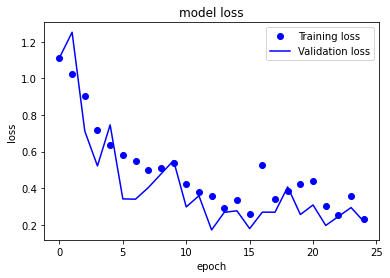

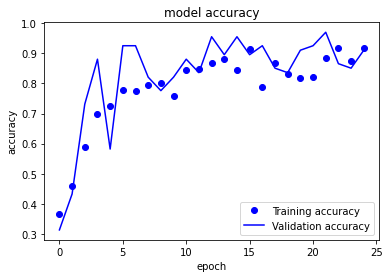

In [138]:
#plotting training model results
plt.plot(opt_lstm_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(opt_lstm_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(opt_lstm_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(opt_lstm_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [80]:
#optimised model testing using training and validation sets.
opt_cnn1_m = Sequential()
opt_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1)))
opt_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu'))
opt_cnn1_m.add(MaxPooling1D(pool_size=1))
opt_cnn1_m.add(BatchNormalization())

opt_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu'))
opt_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu'))
opt_cnn1_m.add(MaxPooling1D(pool_size=1))
opt_cnn1_m.add(BatchNormalization())
    
opt_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu'))
opt_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu'))
opt_cnn1_m.add(MaxPooling1D(pool_size=1))
opt_cnn1_m.add(BatchNormalization())

opt_cnn1_m.add(Flatten())
opt_cnn1_m.add(Dense(64, activation='sigmoid'))
opt_cnn1_m.add(Dropout(0.2))

opt_cnn1_m.add(Dense(3, activation='sigmoid'))
opt_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
opt_cnn1_hist = opt_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 44ms/step - loss: 0.6962 - accuracy: 0.7090 - val_loss: 1.1359 - val_accuracy: 0.3134
Epoch 2/25
27/27 [==============================] - 1s 41ms/step - loss: 0.3456 - accuracy: 0.8881 - val_loss: 1.0783 - val_accuracy: 0.3284
Epoch 3/25
27/27 [==============================] - 1s 41ms/step - loss: 0.3314 - accuracy: 0.8843 - val_loss: 1.0368 - val_accuracy: 0.5224
Epoch 4/25
27/27 [==============================] - 1s 42ms/step - loss: 0.3176 - accuracy: 0.8843 - val_loss: 0.8929 - val_accuracy: 0.6418
Epoch 5/25
27/27 [==============================] - 1s 42ms/step - loss: 0.3144 - accuracy: 0.8955 - val_loss: 0.9345 - val_accuracy: 0.4478
Epoch 6/25
27/27 [==============================] - 1s 41ms/step - loss: 0.2636 - accuracy: 0.9104 - val_loss: 0.7287 - val_accuracy: 0.7463
Epoch 7/25
27/27 [==============================] - 1s 41ms/step - loss: 0.2554 - accuracy: 0.9142 - val_loss: 1.1956 - val_accuracy: 0.4179
Epoch 8/25
27

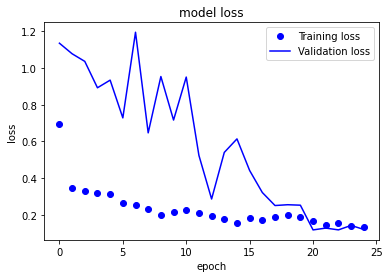

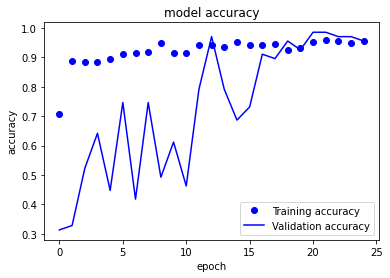

In [139]:
#plotting training model results
plt.plot(opt_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(opt_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(opt_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(opt_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L1 (3)

In [104]:
#regulariser testing using 1e-3
lstm_regL1_3_model = Sequential()
lstm_regL1_3_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l1(1e-3)))
lstm_regL1_3_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l1(1e-3)))
lstm_regL1_3_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l1(1e-3)))
lstm_regL1_3_model.add(Dropout(0.2))
lstm_regL1_3_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL1_3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL1_3_hist = lstm_regL1_3_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 7s 266ms/step - loss: 1.1506 - accuracy: 0.3396 - val_loss: 1.1250 - val_accuracy: 0.3134
Epoch 2/25
27/27 [==============================] - 7s 268ms/step - loss: 1.1129 - accuracy: 0.3881 - val_loss: 1.1157 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 7s 266ms/step - loss: 1.1068 - accuracy: 0.4664 - val_loss: 1.0464 - val_accuracy: 0.5970
Epoch 4/25
27/27 [==============================] - 7s 267ms/step - loss: 1.0395 - accuracy: 0.5746 - val_loss: 0.9404 - val_accuracy: 0.5821
Epoch 5/25
27/27 [==============================] - 7s 263ms/step - loss: 0.8663 - accuracy: 0.6231 - val_loss: 0.6736 - val_accuracy: 0.8060
Epoch 6/25
27/27 [==============================] - 7s 256ms/step - loss: 0.7662 - accuracy: 0.7313 - val_loss: 0.5786 - val_accuracy: 0.8060
Epoch 7/25
27/27 [==============================] - 7s 259ms/step - loss: 0.7446 - accuracy: 0.7201 - val_loss: 0.6276 - val_accuracy: 0.8358
Epoch 

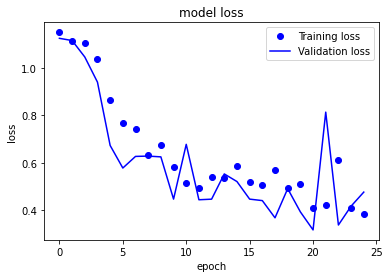

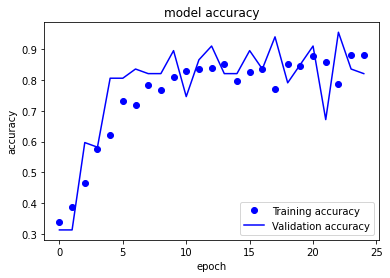

In [124]:
#plotting training model results
plt.plot(lstm_regL1_3_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL1_3_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL1_3_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL1_3_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [105]:
#regulariser testing using 1e-3
regL1_3_cnn1_m = Sequential()
regL1_3_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_3_cnn1_m.add(BatchNormalization())

regL1_3_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_3_cnn1_m.add(BatchNormalization())
    
regL1_3_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-3)))
regL1_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_3_cnn1_m.add(BatchNormalization())

regL1_3_cnn1_m.add(Flatten())
regL1_3_cnn1_m.add(Dense(64, activation='sigmoid'))
regL1_3_cnn1_m.add(Dropout(0.2))

regL1_3_cnn1_m.add(Dense(3, activation='sigmoid'))
regL1_3_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL1_3_cnn1_hist = regL1_3_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 50ms/step - loss: 3.0212 - accuracy: 0.6567 - val_loss: 1.3956 - val_accuracy: 0.3284
Epoch 2/25
27/27 [==============================] - 1s 50ms/step - loss: 1.8879 - accuracy: 0.7985 - val_loss: 1.4158 - val_accuracy: 0.3284
Epoch 3/25
27/27 [==============================] - 1s 51ms/step - loss: 1.3843 - accuracy: 0.8619 - val_loss: 1.4625 - val_accuracy: 0.3284
Epoch 4/25
27/27 [==============================] - 1s 51ms/step - loss: 0.8253 - accuracy: 0.9179 - val_loss: 1.4379 - val_accuracy: 0.3284
Epoch 5/25
27/27 [==============================] - 1s 51ms/step - loss: 0.6213 - accuracy: 0.8993 - val_loss: 1.4627 - val_accuracy: 0.3284
Epoch 6/25
27/27 [==============================] - 1s 52ms/step - loss: 0.5406 - accuracy: 0.9254 - val_loss: 1.4967 - val_accuracy: 0.3284
Epoch 7/25
27/27 [==============================] - 1s 52ms/step - loss: 0.4756 - accuracy: 0.9366 - val_loss: 1.5454 - val_accuracy: 0.3284
Epoch 8/25
27

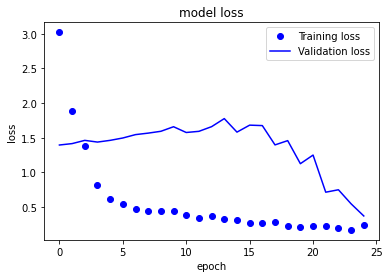

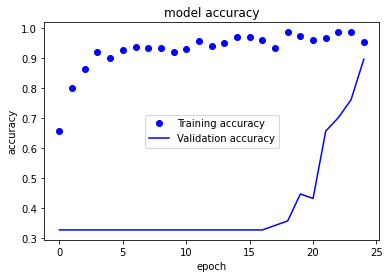

In [125]:
#plotting training model results
plt.plot(regL1_3_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL1_3_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL1_3_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL1_3_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L1 (4)

In [106]:
#regulariser testing using 1e-4
lstm_regL1_4_model = Sequential()
lstm_regL1_4_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l1(1e-4)))
lstm_regL1_4_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l1(1e-4)))
lstm_regL1_4_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l1(1e-4)))
lstm_regL1_4_model.add(Dropout(0.2))
lstm_regL1_4_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL1_4_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL1_4_hist = lstm_regL1_4_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 7s 263ms/step - loss: 1.1064 - accuracy: 0.3507 - val_loss: 1.0575 - val_accuracy: 0.4179
Epoch 2/25
27/27 [==============================] - 7s 261ms/step - loss: 0.9527 - accuracy: 0.5112 - val_loss: 1.1890 - val_accuracy: 0.5373
Epoch 3/25
27/27 [==============================] - 7s 273ms/step - loss: 0.8951 - accuracy: 0.5821 - val_loss: 0.8078 - val_accuracy: 0.5672
Epoch 4/25
27/27 [==============================] - 8s 282ms/step - loss: 0.7608 - accuracy: 0.6418 - val_loss: 0.5054 - val_accuracy: 0.8657
Epoch 5/25
27/27 [==============================] - 7s 267ms/step - loss: 0.6954 - accuracy: 0.7090 - val_loss: 0.7158 - val_accuracy: 0.7015
Epoch 6/25
27/27 [==============================] - 7s 263ms/step - loss: 0.6972 - accuracy: 0.7575 - val_loss: 0.5634 - val_accuracy: 0.7612
Epoch 7/25
27/27 [==============================] - 7s 264ms/step - loss: 0.6389 - accuracy: 0.7164 - val_loss: 0.4849 - val_accuracy: 0.8507
Epoch 

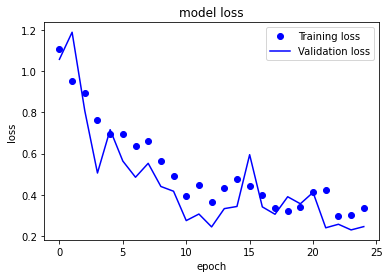

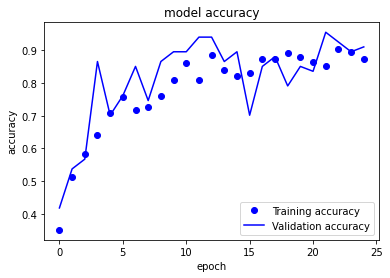

In [126]:
#plotting training model results
plt.plot(lstm_regL1_4_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL1_4_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL1_4_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL1_4_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [107]:
#regulariser testing using 1e-4
regL1_4_cnn1_m = Sequential()
regL1_4_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_4_cnn1_m.add(BatchNormalization())

regL1_4_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_4_cnn1_m.add(BatchNormalization())
    
regL1_4_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
regL1_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_4_cnn1_m.add(BatchNormalization())

regL1_4_cnn1_m.add(Flatten())
regL1_4_cnn1_m.add(Dense(64, activation='sigmoid'))
regL1_4_cnn1_m.add(Dropout(0.2))

regL1_4_cnn1_m.add(Dense(3, activation='sigmoid'))
regL1_4_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL1_4_cnn1_hist = regL1_4_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 54ms/step - loss: 1.2508 - accuracy: 0.6679 - val_loss: 1.1774 - val_accuracy: 0.3284
Epoch 2/25
27/27 [==============================] - 1s 52ms/step - loss: 0.8201 - accuracy: 0.8209 - val_loss: 1.3140 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 1s 50ms/step - loss: 0.6715 - accuracy: 0.8806 - val_loss: 1.2625 - val_accuracy: 0.3134
Epoch 4/25
27/27 [==============================] - 1s 51ms/step - loss: 0.6051 - accuracy: 0.8769 - val_loss: 1.2477 - val_accuracy: 0.3284
Epoch 5/25
27/27 [==============================] - 1s 50ms/step - loss: 0.5354 - accuracy: 0.8843 - val_loss: 1.3437 - val_accuracy: 0.3284
Epoch 6/25
27/27 [==============================] - 1s 52ms/step - loss: 0.4983 - accuracy: 0.9366 - val_loss: 1.3451 - val_accuracy: 0.3284
Epoch 7/25
27/27 [==============================] - 1s 51ms/step - loss: 0.4477 - accuracy: 0.9291 - val_loss: 1.4978 - val_accuracy: 0.3134
Epoch 8/25
27

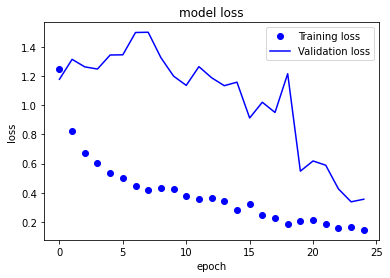

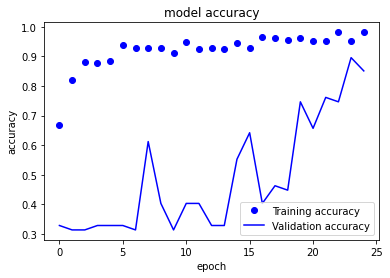

In [127]:
#plotting training model results
plt.plot(regL1_4_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL1_4_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL1_4_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL1_4_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L1 (5)

In [108]:
#regulariser testing using 1e-5
lstm_regL1_5_model = Sequential()
lstm_regL1_5_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l1(1e-5)))
lstm_regL1_5_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l1(1e-5)))
lstm_regL1_5_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l1(1e-5)))
lstm_regL1_5_model.add(Dropout(0.2))
lstm_regL1_5_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL1_5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL1_5_hist = lstm_regL1_5_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 8s 281ms/step - loss: 1.0846 - accuracy: 0.3881 - val_loss: 0.9768 - val_accuracy: 0.4478
Epoch 2/25
27/27 [==============================] - 7s 273ms/step - loss: 0.9395 - accuracy: 0.5224 - val_loss: 0.7972 - val_accuracy: 0.6269
Epoch 3/25
27/27 [==============================] - 7s 272ms/step - loss: 0.7404 - accuracy: 0.6679 - val_loss: 0.5210 - val_accuracy: 0.8060
Epoch 4/25
27/27 [==============================] - 8s 281ms/step - loss: 0.5393 - accuracy: 0.7761 - val_loss: 0.5844 - val_accuracy: 0.8209
Epoch 5/25
27/27 [==============================] - 8s 297ms/step - loss: 0.7076 - accuracy: 0.7090 - val_loss: 0.6847 - val_accuracy: 0.6418
Epoch 6/25
27/27 [==============================] - 7s 276ms/step - loss: 0.5915 - accuracy: 0.7500 - val_loss: 0.9307 - val_accuracy: 0.6567
Epoch 7/25
27/27 [==============================] - 8s 285ms/step - loss: 0.5996 - accuracy: 0.7351 - val_loss: 0.7603 - val_accuracy: 0.6866
Epoch 

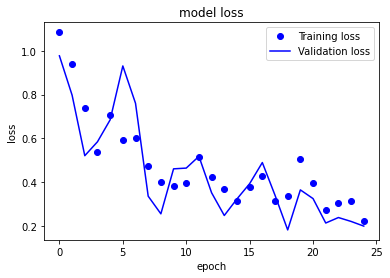

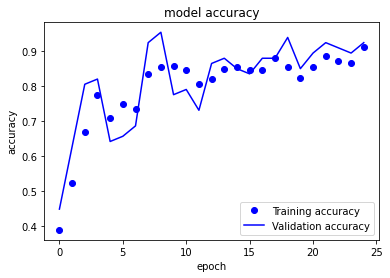

In [128]:
#plotting training model results
plt.plot(lstm_regL1_5_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL1_5_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL1_5_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL1_5_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [109]:
#regulariser testing using 1e-5
regL1_5_cnn1_m = Sequential()
regL1_5_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_5_cnn1_m.add(BatchNormalization())

regL1_5_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_5_cnn1_m.add(BatchNormalization())
    
regL1_5_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l1(1e-5)))
regL1_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL1_5_cnn1_m.add(BatchNormalization())

regL1_5_cnn1_m.add(Flatten())
regL1_5_cnn1_m.add(Dense(64, activation='sigmoid'))
regL1_5_cnn1_m.add(Dropout(0.2))

regL1_5_cnn1_m.add(Dense(3, activation='sigmoid'))
regL1_5_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL1_5_cnn1_hist = regL1_5_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 55ms/step - loss: 0.9340 - accuracy: 0.6306 - val_loss: 1.0953 - val_accuracy: 0.3134
Epoch 2/25
27/27 [==============================] - 1s 55ms/step - loss: 0.4851 - accuracy: 0.8396 - val_loss: 1.3130 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 1s 54ms/step - loss: 0.4659 - accuracy: 0.8433 - val_loss: 1.1335 - val_accuracy: 0.3134
Epoch 4/25
27/27 [==============================] - 1s 53ms/step - loss: 0.4018 - accuracy: 0.8918 - val_loss: 1.1042 - val_accuracy: 0.4776
Epoch 5/25
27/27 [==============================] - 1s 53ms/step - loss: 0.3556 - accuracy: 0.8993 - val_loss: 1.1257 - val_accuracy: 0.3134
Epoch 6/25
27/27 [==============================] - 1s 53ms/step - loss: 0.3163 - accuracy: 0.9104 - val_loss: 1.4061 - val_accuracy: 0.3134
Epoch 7/25
27/27 [==============================] - 2s 56ms/step - loss: 0.3096 - accuracy: 0.9179 - val_loss: 1.4276 - val_accuracy: 0.3134
Epoch 8/25
27

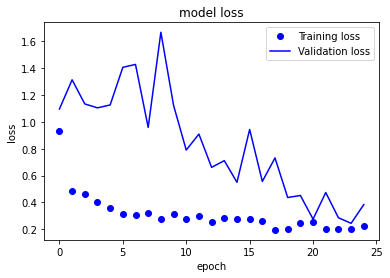

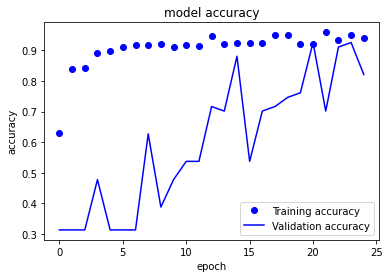

In [129]:
#plotting training model results
plt.plot(regL1_5_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL1_5_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL1_5_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL1_5_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L2 (3)

In [110]:
#regulariser testing using 1e-3
lstm_regL2_3_model = Sequential()
lstm_regL2_3_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l2(1e-3)))
lstm_regL2_3_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l2(1e-3)))
lstm_regL2_3_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l2(1e-3)))
lstm_regL2_3_model.add(Dropout(0.2))
lstm_regL2_3_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL2_3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL2_3_hist = lstm_regL2_3_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 8s 294ms/step - loss: 1.0782 - accuracy: 0.3881 - val_loss: 1.0033 - val_accuracy: 0.4179
Epoch 2/25
27/27 [==============================] - 8s 302ms/step - loss: 0.9176 - accuracy: 0.5746 - val_loss: 0.8322 - val_accuracy: 0.6716
Epoch 3/25
27/27 [==============================] - 8s 289ms/step - loss: 0.8983 - accuracy: 0.5896 - val_loss: 0.8518 - val_accuracy: 0.5821
Epoch 4/25
27/27 [==============================] - 8s 290ms/step - loss: 0.7415 - accuracy: 0.6679 - val_loss: 0.5928 - val_accuracy: 0.7761
Epoch 5/25
27/27 [==============================] - 8s 293ms/step - loss: 0.6303 - accuracy: 0.7351 - val_loss: 0.4616 - val_accuracy: 0.8657
Epoch 6/25
27/27 [==============================] - 8s 293ms/step - loss: 0.5572 - accuracy: 0.7836 - val_loss: 0.4080 - val_accuracy: 0.8657
Epoch 7/25
27/27 [==============================] - 8s 295ms/step - loss: 0.4994 - accuracy: 0.8097 - val_loss: 0.6737 - val_accuracy: 0.7463
Epoch 

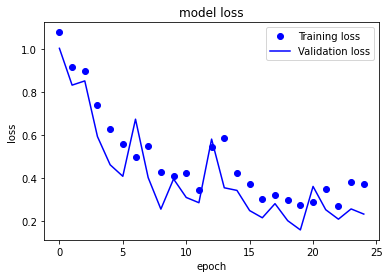

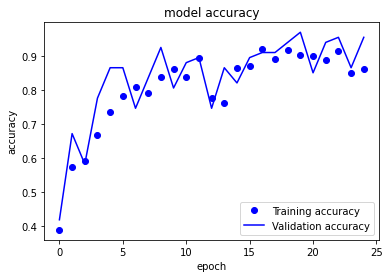

In [130]:
#plotting training model results
plt.plot(lstm_regL2_3_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL2_3_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL2_3_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL2_3_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [111]:
#regulariser testing using 1e-3
regL2_3_cnn1_m = Sequential()
regL2_3_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_3_cnn1_m.add(BatchNormalization())

regL2_3_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_3_cnn1_m.add(BatchNormalization())
    
regL2_3_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
regL2_3_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_3_cnn1_m.add(BatchNormalization())

regL2_3_cnn1_m.add(Flatten())
regL2_3_cnn1_m.add(Dense(64, activation='sigmoid'))
regL2_3_cnn1_m.add(Dropout(0.2))

regL2_3_cnn1_m.add(Dense(3, activation='sigmoid'))
regL2_3_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL2_3_cnn1_hist = regL2_3_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 55ms/step - loss: 1.9468 - accuracy: 0.6530 - val_loss: 1.1372 - val_accuracy: 0.3284
Epoch 2/25
27/27 [==============================] - 1s 54ms/step - loss: 0.9417 - accuracy: 0.8209 - val_loss: 1.1866 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 1s 54ms/step - loss: 0.7320 - accuracy: 0.8918 - val_loss: 1.1964 - val_accuracy: 0.3284
Epoch 4/25
27/27 [==============================] - 1s 54ms/step - loss: 0.5721 - accuracy: 0.8993 - val_loss: 1.2373 - val_accuracy: 0.3284
Epoch 5/25
27/27 [==============================] - 2s 56ms/step - loss: 0.4910 - accuracy: 0.9104 - val_loss: 1.2230 - val_accuracy: 0.3284
Epoch 6/25
27/27 [==============================] - 1s 56ms/step - loss: 0.4544 - accuracy: 0.8955 - val_loss: 1.2354 - val_accuracy: 0.3284
Epoch 7/25
27/27 [==============================] - 1s 55ms/step - loss: 0.3707 - accuracy: 0.9328 - val_loss: 1.3264 - val_accuracy: 0.3284
Epoch 8/25
27

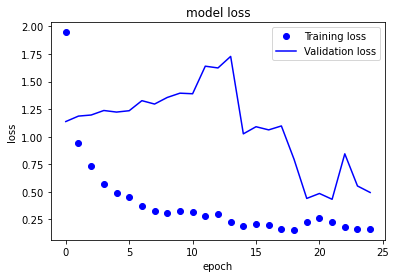

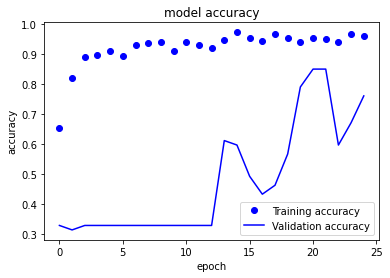

In [131]:
#plotting training model results
plt.plot(regL2_3_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL2_3_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL2_3_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL2_3_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L2 (4)

In [112]:
#regulariser testing using 1e-4
lstm_regL2_4_model = Sequential()
lstm_regL2_4_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l2(1e-4)))
lstm_regL2_4_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l2(1e-4)))
lstm_regL2_4_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l2(1e-4)))
lstm_regL2_4_model.add(Dropout(0.2))
lstm_regL2_4_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL2_4_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL2_4_hist = lstm_regL2_4_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 8s 303ms/step - loss: 1.0946 - accuracy: 0.3806 - val_loss: 1.0701 - val_accuracy: 0.5075
Epoch 2/25
27/27 [==============================] - 9s 336ms/step - loss: 1.0487 - accuracy: 0.4627 - val_loss: 0.9572 - val_accuracy: 0.4627
Epoch 3/25
27/27 [==============================] - 8s 304ms/step - loss: 1.0258 - accuracy: 0.5261 - val_loss: 0.8362 - val_accuracy: 0.7761
Epoch 4/25
27/27 [==============================] - 8s 301ms/step - loss: 0.8386 - accuracy: 0.6231 - val_loss: 0.5817 - val_accuracy: 0.8507
Epoch 5/25
27/27 [==============================] - 8s 298ms/step - loss: 0.7176 - accuracy: 0.7127 - val_loss: 0.7367 - val_accuracy: 0.6418
Epoch 6/25
27/27 [==============================] - 8s 304ms/step - loss: 0.6071 - accuracy: 0.7575 - val_loss: 0.5233 - val_accuracy: 0.7910
Epoch 7/25
27/27 [==============================] - 8s 297ms/step - loss: 0.5152 - accuracy: 0.8134 - val_loss: 0.3350 - val_accuracy: 0.8657
Epoch 

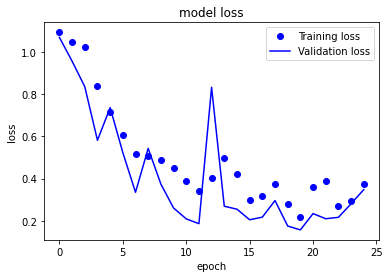

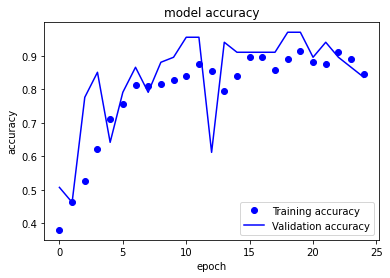

In [132]:
#plotting training model results
plt.plot(lstm_regL2_4_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL2_4_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL2_4_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL2_4_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [113]:
#regulariser testing using 1e-4
regL2_4_cnn1_m = Sequential()
regL2_4_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_4_cnn1_m.add(BatchNormalization())

regL2_4_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_4_cnn1_m.add(BatchNormalization())
    
regL2_4_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-4)))
regL2_4_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_4_cnn1_m.add(BatchNormalization())

regL2_4_cnn1_m.add(Flatten())
regL2_4_cnn1_m.add(Dense(64, activation='sigmoid'))
regL2_4_cnn1_m.add(Dropout(0.2))

regL2_4_cnn1_m.add(Dense(3, activation='sigmoid'))
regL2_4_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL2_4_cnn1_hist = regL2_4_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 2s 57ms/step - loss: 1.0833 - accuracy: 0.6530 - val_loss: 1.1842 - val_accuracy: 0.4030
Epoch 2/25
27/27 [==============================] - 2s 56ms/step - loss: 0.6459 - accuracy: 0.7948 - val_loss: 1.1868 - val_accuracy: 0.3134
Epoch 3/25
27/27 [==============================] - 1s 55ms/step - loss: 0.5141 - accuracy: 0.8619 - val_loss: 1.2597 - val_accuracy: 0.3134
Epoch 4/25
27/27 [==============================] - 1s 55ms/step - loss: 0.3986 - accuracy: 0.9142 - val_loss: 1.2438 - val_accuracy: 0.3284
Epoch 5/25
27/27 [==============================] - 1s 54ms/step - loss: 0.4002 - accuracy: 0.9067 - val_loss: 1.2246 - val_accuracy: 0.4030
Epoch 6/25
27/27 [==============================] - 1s 55ms/step - loss: 0.3751 - accuracy: 0.9104 - val_loss: 1.1851 - val_accuracy: 0.3731
Epoch 7/25
27/27 [==============================] - 1s 56ms/step - loss: 0.3504 - accuracy: 0.9030 - val_loss: 1.1970 - val_accuracy: 0.4328
Epoch 8/25
27

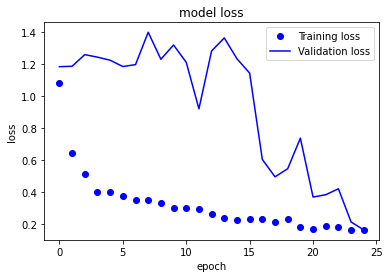

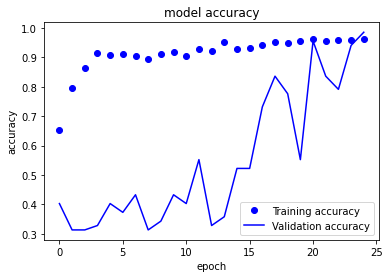

In [133]:
#plotting training model results
plt.plot(regL2_4_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL2_4_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL2_4_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL2_4_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Regularisation - L2 (5)

In [114]:
#regulariser testing using 1e-5
lstm_regL2_5_model = Sequential()
lstm_regL2_5_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
lstm_regL2_5_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
lstm_regL2_5_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l2(1e-5)))
lstm_regL2_5_model.add(Dropout(0.2))
lstm_regL2_5_model.add(Dense(3, activation = 'sigmoid'))
lstm_regL2_5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
lstm_regL2_5_hist = lstm_regL2_5_model.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 9s 326ms/step - loss: 1.1002 - accuracy: 0.3396 - val_loss: 1.0674 - val_accuracy: 0.5821
Epoch 2/25
27/27 [==============================] - 8s 300ms/step - loss: 1.0047 - accuracy: 0.5299 - val_loss: 0.9068 - val_accuracy: 0.5522
Epoch 3/25
27/27 [==============================] - 8s 296ms/step - loss: 0.7997 - accuracy: 0.6604 - val_loss: 0.5797 - val_accuracy: 0.7313
Epoch 4/25
27/27 [==============================] - 9s 328ms/step - loss: 0.6720 - accuracy: 0.6754 - val_loss: 0.4722 - val_accuracy: 0.8358
Epoch 5/25
27/27 [==============================] - 8s 302ms/step - loss: 0.5918 - accuracy: 0.7537 - val_loss: 0.5069 - val_accuracy: 0.7910
Epoch 6/25
27/27 [==============================] - 8s 298ms/step - loss: 0.5838 - accuracy: 0.7313 - val_loss: 0.3535 - val_accuracy: 0.9104
Epoch 7/25
27/27 [==============================] - 8s 290ms/step - loss: 0.5215 - accuracy: 0.7948 - val_loss: 0.4218 - val_accuracy: 0.7761
Epoch 

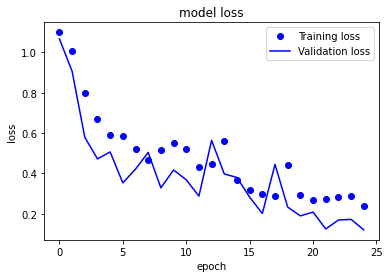

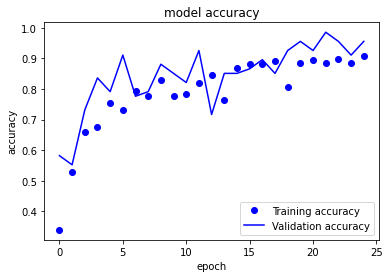

In [134]:
#plotting training model results
plt.plot(lstm_regL2_5_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(lstm_regL2_5_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(lstm_regL2_5_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(lstm_regL2_5_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [117]:
#regulariser testing using 1e-5
regL2_5_cnn1_m = Sequential()
regL2_5_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_5_cnn1_m.add(BatchNormalization())

regL2_5_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_5_cnn1_m.add(BatchNormalization())
    
regL2_5_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))
regL2_5_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_5_cnn1_m.add(BatchNormalization())

regL2_5_cnn1_m.add(Flatten())
regL2_5_cnn1_m.add(Dense(64, activation='sigmoid'))
regL2_5_cnn1_m.add(Dropout(0.2))

regL2_5_cnn1_m.add(Dense(3, activation='sigmoid'))
regL2_5_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL2_5_cnn1_hist = regL2_5_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 52ms/step - loss: 0.7573 - accuracy: 0.6791 - val_loss: 1.1613 - val_accuracy: 0.4328
Epoch 2/25
27/27 [==============================] - 1s 51ms/step - loss: 0.4376 - accuracy: 0.8731 - val_loss: 1.2349 - val_accuracy: 0.3284
Epoch 3/25
27/27 [==============================] - 1s 50ms/step - loss: 0.4018 - accuracy: 0.8769 - val_loss: 1.1581 - val_accuracy: 0.3134
Epoch 4/25
27/27 [==============================] - 1s 51ms/step - loss: 0.3346 - accuracy: 0.9254 - val_loss: 1.0529 - val_accuracy: 0.3731
Epoch 5/25
27/27 [==============================] - 1s 53ms/step - loss: 0.3639 - accuracy: 0.8918 - val_loss: 1.1302 - val_accuracy: 0.3881
Epoch 6/25
27/27 [==============================] - 1s 53ms/step - loss: 0.2807 - accuracy: 0.9142 - val_loss: 1.2915 - val_accuracy: 0.3284
Epoch 7/25
27/27 [==============================] - 1s 53ms/step - loss: 0.2622 - accuracy: 0.9366 - val_loss: 1.0051 - val_accuracy: 0.3582
Epoch 8/25
27

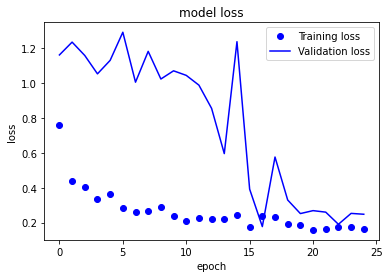

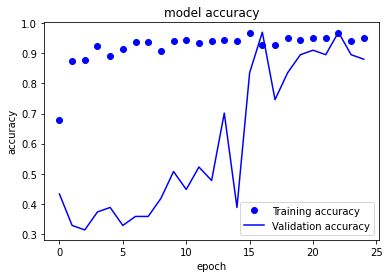

In [135]:
#plotting training model results
plt.plot(regL2_5_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL2_5_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL2_5_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL2_5_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Further L2 Regulariser Testing: 1D CNN

In [152]:
#regulariser testing using 1e-9
regL2_9_cnn1_m = Sequential()
regL2_9_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_9_cnn1_m.add(BatchNormalization())

regL2_9_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_9_cnn1_m.add(BatchNormalization())
    
regL2_9_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
regL2_9_cnn1_m.add(MaxPooling1D(pool_size=1))
regL2_9_cnn1_m.add(BatchNormalization())

regL2_9_cnn1_m.add(Flatten())
regL2_9_cnn1_m.add(Dense(64, activation='sigmoid'))
regL2_9_cnn1_m.add(Dropout(0.2))

regL2_9_cnn1_m.add(Dense(3, activation='sigmoid'))
regL2_9_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
regL2_9_cnn1_hist = regL2_9_cnn1_m.fit(market_train_l, new_train_labs, validation_data=(market_test_l,new_test_labs), epochs=25, batch_size = 10)

Epoch 1/25
27/27 [==============================] - 1s 53ms/step - loss: 0.8403 - accuracy: 0.6791 - val_loss: 1.0578 - val_accuracy: 0.4627
Epoch 2/25
27/27 [==============================] - 1s 51ms/step - loss: 0.4861 - accuracy: 0.7985 - val_loss: 1.1652 - val_accuracy: 0.3881
Epoch 3/25
27/27 [==============================] - 1s 51ms/step - loss: 0.3868 - accuracy: 0.8396 - val_loss: 1.3293 - val_accuracy: 0.3284
Epoch 4/25
27/27 [==============================] - 1s 50ms/step - loss: 0.3011 - accuracy: 0.9179 - val_loss: 0.9166 - val_accuracy: 0.3881
Epoch 5/25
27/27 [==============================] - 1s 51ms/step - loss: 0.2586 - accuracy: 0.9142 - val_loss: 0.9357 - val_accuracy: 0.6119
Epoch 6/25
27/27 [==============================] - 1s 51ms/step - loss: 0.2484 - accuracy: 0.9403 - val_loss: 1.9574 - val_accuracy: 0.3284
Epoch 7/25
27/27 [==============================] - 1s 51ms/step - loss: 0.2457 - accuracy: 0.9254 - val_loss: 0.6696 - val_accuracy: 0.7612
Epoch 8/25
27

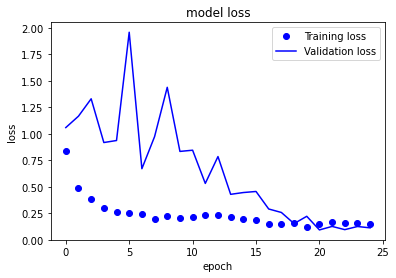

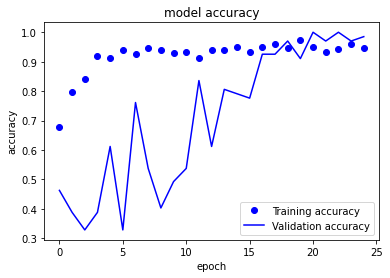

In [153]:
#plotting training model results
plt.plot(regL2_9_cnn1_hist.history['loss'], blue_dots, label = 'Training loss')
plt.plot(regL2_9_cnn1_hist.history['val_loss'], solid_blue_line, label = 'Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(regL2_9_cnn1_hist.history['accuracy'], blue_dots, label = 'Training accuracy')
plt.plot(regL2_9_cnn1_hist.history['val_accuracy'], solid_blue_line, label = 'Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Final Model Testing

In [155]:
#final model cross validation
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
final_LSTM_CV = pd.DataFrame()
final_LSTM_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    final_LSTM_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    lstm_regfin_model = Sequential()
    lstm_regfin_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
    lstm_regfin_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
    lstm_regfin_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l2(1e-5)))
    lstm_regfin_model.add(Dropout(0.2))
    lstm_regfin_model.add(Dense(3, activation = 'sigmoid'))
    lstm_regfin_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    lstm_regfin_model.fit(market_train_n, new_labs_k, epochs=25, batch_size = 10)
    resultsTest = lstm_regfin_model.evaluate(market_test_n, new_labs_k_test, batch_size=30)
    final_LSTM_results.append(resultsTest[0])
    final_LSTM_results.append(resultsTest[1])
    final_LSTM_cv_results.append(final_LSTM_results)

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 243ms/step - loss: 1.1088 - accuracy: 0.3527
Epoch 2/25
25/25 [==============================] - 6s 238ms/step - loss: 1.0509 - accuracy: 0.4274
Epoch 3/25
25/25 [==============================] - 6s 239ms/step - loss: 0.8884 - accuracy: 0.5685
Epoch 4/25
25/25 [==============================] - 6s 238ms/step - loss: 0.8583 - accuracy: 0.6349
Epoch 5/25
25/25 [==============================] - 7s 275ms/step - loss: 0.8007 - accuracy: 0.6224
Epoch 6/25
25/25 [==============================] - 6s 242ms/step - loss: 0.6252 - accuracy: 0.7261
Epoch 7/25
25/25 [==============================] - 6s 241ms/step - loss: 0.7873 - accuracy: 0.6432
Epoch 8/25
25/25 [==============================] - 6s 244ms/step - loss: 0.6856 - accuracy: 0.7344
Epoch 9/25
25/25 [==============================] - 6s 240ms/step - loss: 0.5633 - accuracy: 0.7593
Epoch 10/25
25/25 [==============================] - 6s 243ms/step - loss: 0.5130 - accuracy: 0.7967

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 236ms/step - loss: 1.0929 - accuracy: 0.3983
Epoch 2/25
25/25 [==============================] - 6s 247ms/step - loss: 1.0569 - accuracy: 0.4149
Epoch 3/25
25/25 [==============================] - 6s 238ms/step - loss: 0.9649 - accuracy: 0.5685
Epoch 4/25
25/25 [==============================] - 6s 237ms/step - loss: 0.9008 - accuracy: 0.5436
Epoch 5/25
25/25 [==============================] - 6s 244ms/step - loss: 0.7963 - accuracy: 0.6556
Epoch 6/25
25/25 [==============================] - 6s 236ms/step - loss: 0.6676 - accuracy: 0.6888
Epoch 7/25
25/25 [==============================] - 6s 239ms/step - loss: 0.7603 - accuracy: 0.6598
Epoch 8/25
25/25 [==============================] - 6s 250ms/step - loss: 0.6140 - accuracy: 0.7427
Epoch 9/25
25/25 [==============================] - 6s 241ms/step - loss: 0.5912 - accuracy: 0.7718
Epoch 10/25
25/25 [==============================] - 6s 238ms/step - loss: 0.6893 - accuracy: 0.7303

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 249ms/step - loss: 1.0738 - accuracy: 0.4274
Epoch 2/25
25/25 [==============================] - 6s 243ms/step - loss: 1.0648 - accuracy: 0.3983
Epoch 3/25
25/25 [==============================] - 6s 242ms/step - loss: 0.8937 - accuracy: 0.5602
Epoch 4/25
25/25 [==============================] - 6s 239ms/step - loss: 0.7491 - accuracy: 0.6805
Epoch 5/25
25/25 [==============================] - 6s 239ms/step - loss: 0.6483 - accuracy: 0.7344
Epoch 6/25
25/25 [==============================] - 6s 237ms/step - loss: 0.8184 - accuracy: 0.6598
Epoch 7/25
25/25 [==============================] - 6s 236ms/step - loss: 0.6338 - accuracy: 0.7386
Epoch 8/25
25/25 [==============================] - 6s 235ms/step - loss: 0.5037 - accuracy: 0.8008
Epoch 9/25
25/25 [==============================] - 6s 247ms/step - loss: 0.8164 - accuracy: 0.6556
Epoch 10/25
25/25 [==============================] - 6s 251ms/step - loss: 0.7947 - accuracy: 0.6224

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 242ms/step - loss: 1.1118 - accuracy: 0.3444
Epoch 2/25
25/25 [==============================] - 6s 242ms/step - loss: 1.0381 - accuracy: 0.4689
Epoch 3/25
25/25 [==============================] - 6s 249ms/step - loss: 0.9863 - accuracy: 0.5519
Epoch 4/25
25/25 [==============================] - 6s 248ms/step - loss: 0.7283 - accuracy: 0.6598
Epoch 5/25
25/25 [==============================] - 6s 238ms/step - loss: 0.7127 - accuracy: 0.7220
Epoch 6/25
25/25 [==============================] - 6s 234ms/step - loss: 0.6437 - accuracy: 0.7303
Epoch 7/25
25/25 [==============================] - 6s 234ms/step - loss: 0.7302 - accuracy: 0.6515
Epoch 8/25
25/25 [==============================] - 6s 234ms/step - loss: 0.5017 - accuracy: 0.7967
Epoch 9/25
25/25 [==============================] - 6s 234ms/step - loss: 0.6504 - accuracy: 0.7178
Epoch 10/25
25/25 [==============================] - 6s 241ms/step - loss: 0.5884 - accuracy: 0.7552

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 234ms/step - loss: 1.1117 - accuracy: 0.3527
Epoch 2/25
25/25 [==============================] - 6s 235ms/step - loss: 1.0962 - accuracy: 0.4357
Epoch 3/25
25/25 [==============================] - 6s 235ms/step - loss: 1.0453 - accuracy: 0.4772
Epoch 4/25
25/25 [==============================] - 6s 233ms/step - loss: 0.8430 - accuracy: 0.5519
Epoch 5/25
25/25 [==============================] - 6s 233ms/step - loss: 0.7095 - accuracy: 0.6888
Epoch 6/25
25/25 [==============================] - 6s 233ms/step - loss: 0.8259 - accuracy: 0.6598
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6568 - accuracy: 0.7427
Epoch 8/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6472 - accuracy: 0.7427
Epoch 9/25
25/25 [==============================] - 6s 243ms/step - loss: 0.6306 - accuracy: 0.7095
Epoch 10/25
25/25 [==============================] - 6s 234ms/step - loss: 0.6357 - accuracy: 0.7469

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 233ms/step - loss: 1.1027 - accuracy: 0.3651
Epoch 2/25
25/25 [==============================] - 6s 232ms/step - loss: 1.0921 - accuracy: 0.3568
Epoch 3/25
25/25 [==============================] - 6s 233ms/step - loss: 1.0549 - accuracy: 0.5104
Epoch 4/25
25/25 [==============================] - 6s 233ms/step - loss: 0.9395 - accuracy: 0.5560
Epoch 5/25
25/25 [==============================] - 6s 233ms/step - loss: 0.8587 - accuracy: 0.5768
Epoch 6/25
25/25 [==============================] - 6s 233ms/step - loss: 0.7306 - accuracy: 0.6722
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6421 - accuracy: 0.6971
Epoch 8/25
25/25 [==============================] - 6s 235ms/step - loss: 0.5840 - accuracy: 0.7884
Epoch 9/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6446 - accuracy: 0.7261
Epoch 10/25
25/25 [==============================] - 6s 234ms/step - loss: 0.7184 - accuracy: 0.7054

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 233ms/step - loss: 1.1124 - accuracy: 0.3485
Epoch 2/25
25/25 [==============================] - 6s 232ms/step - loss: 1.0599 - accuracy: 0.4689
Epoch 3/25
25/25 [==============================] - 6s 233ms/step - loss: 0.9324 - accuracy: 0.5851
Epoch 4/25
25/25 [==============================] - 6s 234ms/step - loss: 0.9408 - accuracy: 0.5187
Epoch 5/25
25/25 [==============================] - 6s 241ms/step - loss: 1.0660 - accuracy: 0.4481
Epoch 6/25
25/25 [==============================] - 6s 233ms/step - loss: 0.9573 - accuracy: 0.5062
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.7281 - accuracy: 0.6846
Epoch 8/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6567 - accuracy: 0.7137
Epoch 9/25
25/25 [==============================] - 6s 233ms/step - loss: 0.7008 - accuracy: 0.6971
Epoch 10/25
25/25 [==============================] - 6s 233ms/step - loss: 0.5836 - accuracy: 0.7303

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 233ms/step - loss: 1.1094 - accuracy: 0.3444
Epoch 2/25
25/25 [==============================] - 6s 232ms/step - loss: 1.0880 - accuracy: 0.3651
Epoch 3/25
25/25 [==============================] - 6s 232ms/step - loss: 0.9941 - accuracy: 0.4979
Epoch 4/25
25/25 [==============================] - 6s 232ms/step - loss: 1.0772 - accuracy: 0.4606
Epoch 5/25
25/25 [==============================] - 6s 234ms/step - loss: 0.8371 - accuracy: 0.6349
Epoch 6/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6434 - accuracy: 0.7303
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6016 - accuracy: 0.7261
Epoch 8/25
25/25 [==============================] - 6s 233ms/step - loss: 0.5875 - accuracy: 0.7510
Epoch 9/25
25/25 [==============================] - 6s 233ms/step - loss: 0.5755 - accuracy: 0.7801
Epoch 10/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6476 - accuracy: 0.7261

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 243ms/step - loss: 1.0957 - accuracy: 0.3595
Epoch 2/25
25/25 [==============================] - 6s 246ms/step - loss: 1.0539 - accuracy: 0.4298
Epoch 3/25
25/25 [==============================] - 6s 234ms/step - loss: 0.9333 - accuracy: 0.5744
Epoch 4/25
25/25 [==============================] - 6s 233ms/step - loss: 0.8908 - accuracy: 0.5620
Epoch 5/25
25/25 [==============================] - 6s 234ms/step - loss: 0.7861 - accuracy: 0.6488
Epoch 6/25
25/25 [==============================] - 6s 234ms/step - loss: 0.6354 - accuracy: 0.7314
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.5380 - accuracy: 0.7645
Epoch 8/25
25/25 [==============================] - 6s 233ms/step - loss: 0.7588 - accuracy: 0.6942
Epoch 9/25
25/25 [==============================] - 6s 240ms/step - loss: 0.5321 - accuracy: 0.7975
Epoch 10/25
25/25 [==============================] - 6s 233ms/step - loss: 0.4851 - accuracy: 0.8099

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 6s 233ms/step - loss: 1.0924 - accuracy: 0.3512
Epoch 2/25
25/25 [==============================] - 6s 233ms/step - loss: 0.8958 - accuracy: 0.5909
Epoch 3/25
25/25 [==============================] - 6s 234ms/step - loss: 0.8520 - accuracy: 0.5744
Epoch 4/25
25/25 [==============================] - 6s 233ms/step - loss: 0.6633 - accuracy: 0.7190
Epoch 5/25
25/25 [==============================] - 6s 237ms/step - loss: 0.6022 - accuracy: 0.7645
Epoch 6/25
25/25 [==============================] - 6s 252ms/step - loss: 0.5497 - accuracy: 0.7893
Epoch 7/25
25/25 [==============================] - 6s 233ms/step - loss: 0.5502 - accuracy: 0.7769
Epoch 8/25
25/25 [==============================] - 6s 232ms/step - loss: 0.4579 - accuracy: 0.8099
Epoch 9/25
25/25 [==============================] - 6s 233ms/step - loss: 0.4755 - accuracy: 0.7975
Epoch 10/25
25/25 [==============================] - 6s 233ms/step - loss: 0.4529 - accuracy: 0.8058

In [157]:
#final cross validation results
final_LSTM_cv = pd.DataFrame(final_LSTM_cv_results, 
             columns=['Loss', 'Accuracy'])
final_LSTM_cv

,Loss,Accuracy
0,0.286219,0.888889
1,0.458732,0.777778
2,0.527203,0.814815
3,0.489194,0.888889
4,0.287479,0.814815
5,0.273017,0.888889
6,0.460971,0.777778
7,0.298765,0.925926
8,0.533329,0.846154
9,0.418359,0.846154


In [171]:
#final lstm model testing using training and validation sets
lstm_final_model = Sequential()
lstm_final_model.add(LSTM(352, activation = 'tanh', input_shape=(30, 1), return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
lstm_final_model.add(LSTM(256, activation = 'tanh', return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
lstm_final_model.add(LSTM(160, activation = 'tanh', return_sequences=False, activity_regularizer=regularizers.l2(1e-5)))
lstm_final_model.add(Dropout(0.2))
lstm_final_model.add(Dense(3, activation = 'sigmoid'))
lstm_final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
    
lstm_final_model.fit(market_train_l, new_train_labs, epochs=25, batch_size = 10)

final_resultsTest = lstm_final_model.evaluate(market_test_l, new_test_labs, batch_size=30)

Epoch 1/25
27/27 [==============================] - 7s 255ms/step - loss: 1.1175 - accuracy: 0.3358 - precision_m: 0.3545 - recall_m: 0.6574 - f1_m: 0.4536
Epoch 2/25
27/27 [==============================] - 7s 257ms/step - loss: 1.0654 - accuracy: 0.4552 - precision_m: 0.4117 - recall_m: 0.7093 - f1_m: 0.5166
Epoch 3/25
27/27 [==============================] - 7s 249ms/step - loss: 0.8104 - accuracy: 0.6082 - precision_m: 0.4992 - recall_m: 0.8361 - f1_m: 0.6233
Epoch 4/25
27/27 [==============================] - 7s 277ms/step - loss: 0.8173 - accuracy: 0.6194 - precision_m: 0.4989 - recall_m: 0.8731 - f1_m: 0.6342
Epoch 5/25
27/27 [==============================] - 7s 278ms/step - loss: 0.6597 - accuracy: 0.7015 - precision_m: 0.5389 - recall_m: 0.9148 - f1_m: 0.6768
Epoch 6/25
27/27 [==============================] - 7s 250ms/step - loss: 0.5350 - accuracy: 0.7612 - precision_m: 0.5807 - recall_m: 0.9444 - f1_m: 0.7179
Epoch 7/25
27/27 [==============================] - 7s 244ms/ste

In [175]:
#training and validation performance metrics
final_LSTM = pd.DataFrame([final_resultsTest], columns=['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
final_LSTM

,Loss,Accuracy,Precision,Recall,F1 Score
0,0.207013,0.925373,0.665368,0.952381,0.783342


In [156]:
#final model cross validation 
X = market_train
y = type_train
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
final_CNN_CV = pd.DataFrame()
final_CNN_cv_results = []

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    final_CNN_results = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    type_train_d = np.array(y_train).astype("float32")
    type_test_d = np.array(y_test).astype("float32")

    enc = LabelEncoder()
    enc.fit(type_train_d)
    new_types = enc.transform(type_train_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k = ohe.fit_transform(new_types)
    
    enc.fit(type_test_d)
    new_types = enc.transform(type_test_d)
    new_types = new_types.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    new_labs_k_test = ohe.fit_transform(new_types)
    
    market_train_n = tf.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    market_train_n.shape
    
    market_test_n = tf.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
    market_test_n.shape
    
    Final_cnn1_m = Sequential()
    Final_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(MaxPooling1D(pool_size=1))
    Final_cnn1_m.add(BatchNormalization())

    Final_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(MaxPooling1D(pool_size=1))
    Final_cnn1_m.add(BatchNormalization())
    
    Final_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
    Final_cnn1_m.add(MaxPooling1D(pool_size=1))
    Final_cnn1_m.add(BatchNormalization())

    Final_cnn1_m.add(Flatten())
    Final_cnn1_m.add(Dense(64, activation='sigmoid'))
    Final_cnn1_m.add(Dropout(0.2))

    Final_cnn1_m.add(Dense(3, activation='sigmoid'))
    Final_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    Final_cnn1_m.fit(market_train_n, new_labs_k, epochs=25, batch_size = 10)
    resultsTest = Final_cnn1_m.evaluate(market_test_n, new_labs_k_test, batch_size=30)
    final_CNN_results.append(resultsTest[0])
    final_CNN_results.append(resultsTest[1])
    final_CNN_cv_results.append(final_CNN_results)

Epoch 1/25
 3/25 [==>...........................] - ETA: 0s - loss: 1.1058 - accuracy: 0.5333

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 46ms/step - loss: 0.7236 - accuracy: 0.6805
Epoch 2/25
25/25 [==============================] - 1s 44ms/step - loss: 0.4704 - accuracy: 0.7967
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3388 - accuracy: 0.8755
Epoch 4/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3938 - accuracy: 0.8133
Epoch 5/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3113 - accuracy: 0.8880
Epoch 6/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2941 - accuracy: 0.9212
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2736 - accuracy: 0.9004
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2821 - accuracy: 0.9129
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2663 - accuracy: 0.9129
Epoch 10/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2199 - accuracy: 0.9295
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 46ms/step - loss: 0.7579 - accuracy: 0.6598
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3684 - accuracy: 0.8465
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3482 - accuracy: 0.8838
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2889 - accuracy: 0.9046
Epoch 5/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2569 - accuracy: 0.9170
Epoch 6/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2799 - accuracy: 0.9004
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2833 - accuracy: 0.8797
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2971 - accuracy: 0.8838
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2311 - accuracy: 0.9170
Epoch 10/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2684 - accuracy: 0.9129
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 45ms/step - loss: 0.8221 - accuracy: 0.6307
Epoch 2/25
25/25 [==============================] - 1s 46ms/step - loss: 0.4173 - accuracy: 0.8506
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3471 - accuracy: 0.9046
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2761 - accuracy: 0.9253
Epoch 5/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2590 - accuracy: 0.9419
Epoch 6/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2625 - accuracy: 0.9170
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2350 - accuracy: 0.9336
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2161 - accuracy: 0.9295
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2828 - accuracy: 0.9004
Epoch 10/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2367 - accuracy: 0.9295
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 45ms/step - loss: 0.8825 - accuracy: 0.6266
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3548 - accuracy: 0.8838
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3273 - accuracy: 0.8755
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2830 - accuracy: 0.9087
Epoch 5/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2331 - accuracy: 0.9253
Epoch 6/25
25/25 [==============================] - 1s 46ms/step - loss: 0.1981 - accuracy: 0.9544
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.1928 - accuracy: 0.9502
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2191 - accuracy: 0.9336
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.1999 - accuracy: 0.9419
Epoch 10/25
25/25 [==============================] - 1s 45ms/step - loss: 0.1734 - accuracy: 0.9336
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 45ms/step - loss: 0.9077 - accuracy: 0.6598
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.4579 - accuracy: 0.8423
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3688 - accuracy: 0.8838
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3074 - accuracy: 0.8880
Epoch 5/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2902 - accuracy: 0.9170
Epoch 6/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2800 - accuracy: 0.8963
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2633 - accuracy: 0.9087
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2460 - accuracy: 0.9129
Epoch 9/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2472 - accuracy: 0.9046
Epoch 10/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2270 - accuracy: 0.9295
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 45ms/step - loss: 0.8407 - accuracy: 0.6639
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.4528 - accuracy: 0.8299
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3596 - accuracy: 0.8921
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3378 - accuracy: 0.9004
Epoch 5/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2772 - accuracy: 0.9170
Epoch 6/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2541 - accuracy: 0.9419
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2665 - accuracy: 0.8963
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2288 - accuracy: 0.9295
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2231 - accuracy: 0.9004
Epoch 10/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2216 - accuracy: 0.9295
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 46ms/step - loss: 0.7043 - accuracy: 0.7095
Epoch 2/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3975 - accuracy: 0.8755
Epoch 3/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3169 - accuracy: 0.9046
Epoch 4/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3152 - accuracy: 0.8963
Epoch 5/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2896 - accuracy: 0.9170
Epoch 6/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2350 - accuracy: 0.9295
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2358 - accuracy: 0.9295
Epoch 8/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2590 - accuracy: 0.9295
Epoch 9/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2203 - accuracy: 0.9378
Epoch 10/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2139 - accuracy: 0.9378
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
25/25 [==============================] - 1s 46ms/step - loss: 0.6785 - accuracy: 0.7012
Epoch 2/25
25/25 [==============================] - 1s 47ms/step - loss: 0.3668 - accuracy: 0.8921
Epoch 3/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3275 - accuracy: 0.8963
Epoch 4/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2463 - accuracy: 0.9253
Epoch 5/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3633 - accuracy: 0.8548
Epoch 6/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2173 - accuracy: 0.9544
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2266 - accuracy: 0.9295
Epoch 8/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2409 - accuracy: 0.9129
Epoch 9/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2284 - accuracy: 0.9087
Epoch 10/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2336 - accuracy: 0.9253
Epoch 11/

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 46ms/step - loss: 0.6995 - accuracy: 0.6983
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3530 - accuracy: 0.8678
Epoch 3/25
25/25 [==============================] - 1s 46ms/step - loss: 0.3087 - accuracy: 0.9050
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3049 - accuracy: 0.9008
Epoch 5/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2428 - accuracy: 0.9215
Epoch 6/25
25/25 [==============================] - 1s 47ms/step - loss: 0.2373 - accuracy: 0.9380
Epoch 7/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2479 - accuracy: 0.9215
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2859 - accuracy: 0.8967
Epoch 9/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2520 - accuracy: 0.9215
Epoch 10/25
25/25 [==============================] - 1s 45ms/step - loss: 0.1866 - accuracy: 0.9421
Epoch 11/25
25/25 [=

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 46ms/step - loss: 0.6264 - accuracy: 0.7355
Epoch 2/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3812 - accuracy: 0.8512
Epoch 3/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2813 - accuracy: 0.8884
Epoch 4/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3017 - accuracy: 0.9132
Epoch 5/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3435 - accuracy: 0.8926
Epoch 6/25
25/25 [==============================] - 1s 45ms/step - loss: 0.3536 - accuracy: 0.8678
Epoch 7/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2746 - accuracy: 0.9132
Epoch 8/25
25/25 [==============================] - 1s 45ms/step - loss: 0.2348 - accuracy: 0.9132
Epoch 9/25
25/25 [==============================] - 1s 46ms/step - loss: 0.2111 - accuracy: 0.9504
Epoch 10/25
25/25 [==============================] - 1s 45ms/step - loss: 0.1816 - accuracy: 0.9421
Epoch 11/25
25/25 [=

In [158]:
#final 1d cnn model cross validation results
final_CNN_cv = pd.DataFrame(final_CNN_cv_results, 
             columns=['Loss', 'Accuracy'])
final_CNN_cv

,Loss,Accuracy
0,0.175688,0.925926
1,0.228576,0.888889
2,0.321445,0.814815
3,0.377302,0.925926
4,0.196159,0.925926
5,0.136219,0.925926
6,0.268640,0.851852
7,0.203691,0.962963
8,0.111868,1.000000
9,0.127655,0.961538


In [176]:
#building final 1d cnn model and running training and validation sets
Final_cnn1_m = Sequential()
Final_cnn1_m.add(Conv1D(320, kernel_size=1, activation='relu', input_shape=(30, 1), activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(Conv1D(288, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(MaxPooling1D(pool_size=1))
Final_cnn1_m.add(BatchNormalization())

Final_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(Conv1D(160, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(MaxPooling1D(pool_size=1))
Final_cnn1_m.add(BatchNormalization())
    
Final_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(Conv1D(256, kernel_size=1, activation='relu', activity_regularizer=regularizers.l2(1e-9)))
Final_cnn1_m.add(MaxPooling1D(pool_size=1))
Final_cnn1_m.add(BatchNormalization())

Final_cnn1_m.add(Flatten())
Final_cnn1_m.add(Dense(64, activation='sigmoid'))
Final_cnn1_m.add(Dropout(0.2))

Final_cnn1_m.add(Dense(3, activation='sigmoid'))
Final_cnn1_m.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', precision_m, recall_m, f1_m])
    
Final_cnn1_m.fit(market_train_l, new_train_labs, epochs=25, batch_size = 10)
final_CNN_resultsTest = Final_cnn1_m.evaluate(market_test_l, new_test_labs, batch_size=30)

C:\Users\jkryo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
27/27 [==============================] - 2s 54ms/step - loss: 0.7384 - accuracy: 0.6716 - precision_m: 0.6065 - recall_m: 0.7509 - f1_m: 0.6640
Epoch 2/25
27/27 [==============================] - 2s 57ms/step - loss: 0.4171 - accuracy: 0.8619 - precision_m: 0.6666 - recall_m: 0.8815 - f1_m: 0.7561
Epoch 3/25
27/27 [==============================] - 2s 56ms/step - loss: 0.4093 - accuracy: 0.8396 - precision_m: 0.7397 - recall_m: 0.8667 - f1_m: 0.7958
Epoch 4/25
27/27 [==============================] - 1s 55ms/step - loss: 0.3576 - accuracy: 0.8881 - precision_m: 0.7120 - recall_m: 0.9074 - f1_m: 0.7954
Epoch 5/25
27/27 [==============================] - 1s 55ms/step - loss: 0.2896 - accuracy: 0.9366 - precision_m: 0.7603 - recall_m: 0.9176 - f1_m: 0.8287
Epoch 6/25
27/27 [==============================] - 1s 55ms/step - loss: 0.2851 - accuracy: 0.9104 - precision_m: 0.7972 - recall_m: 0.9222 - f1_m: 0.8522
Epoch 7/25
27/27 [==============================] - 1s 55ms/step - los

In [177]:
#final 1d cnn performance metrics
final_CNN = pd.DataFrame([final_CNN_resultsTest], columns=['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
final_CNN

,Loss,Accuracy,Precision,Recall,F1 Score
0,0.186482,0.895522,0.749781,0.933333,0.828589


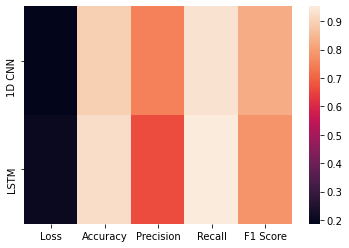

In [257]:
#comparison heatmaps of LSTM and 1d cnns
perf_df = pd.DataFrame(columns=['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
perf_df = perf_df.append(final_CNN)
perf_df = perf_df.append(final_LSTM)
perf_df.index = ['1D CNN', 'LSTM']
ax = sns.heatmap(perf_df)

# Fetching Live Data

In [215]:
howLong = 31
# Calculate the timestamps for the binance api function
untilThisDate = datetime.datetime.now()
sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
# Execute the query from binance - timestamps must be converted to strings !
live_candle = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1DAY, str(sinceThisDate), str(untilThisDate))

# Create a dataframe to label all the columns returned by binance so we work with them later.
live_df = pd.DataFrame(live_candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
# as timestamp is returned in ms, let us convert this back to proper timestamps.
live_df.dateTime = pd.to_datetime(live_df.dateTime, unit='ms')

# Get rid of columns we do not need
live_df = live_df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore', 'high', 'close', 'low', 'volume', 'dateTime'], axis=1)

# Pre-processing Live Data

In [217]:
#pre-processing live data
model_input = live_df.to_numpy()
model_input = model_input.reshape((-1,30))

x_scaled = min_max_scaler.fit_transform(model_input)
model_input = pd.DataFrame(x_scaled)
model_input = np.array(model_input).astype("float32")
model_input = tf.reshape(model_input,(model_input.shape[0], model_input.shape[1], 1))

# Model Predictions on Live Data

In [242]:
#producing predictions using the final 1d cnn model
CNN_prediction = Final_cnn1_m.predict(model_input)
CNN_decoded = np.argmax(CNN_prediction, axis=1)
print(CATEGORIES[int(decoded[0])-1])

Bullish


In [244]:
#producing predictions using the final LSTM model
LSTM_prediction = lstm_final_model.predict(model_input)
LSTM_decoded = np.argmax(LSTM_prediction, axis=1)
print(CATEGORIES[int(decoded[0])-1])

Bullish


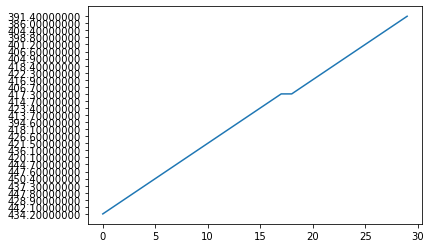

In [243]:
#plotting live data prices to date to review the prediction and what the actual market shows (favourable market/bull market).
plt.plot(live_df["open"])
plt.show()